# About this project: 
Olist is an e-commerce site of Brazil which provides a better platform to connect merchants and their product to the main marketplace of Brazil. It 
provides good services for the merchants to sell their products through the Olist Store and ship them directly to the customers using Olist logistic
partners. 
    
The data-set has information of 100k orders from 2016 to 2018 made at multiple marketplaces in Brazil. Its features allow viewing an order from 
multiple dimensions: from order status, price, payment and freight performance to customer location, product attributes and finally reviews written by 
customers.

The objective of Olist this year is to grow total sales revenue (Olist has no control over the prices and shipping charges set by its partners).


# Table of contents:
Prepare Data and Load Data

Clean Data: Merge Table, Dedublicate, Datatype, Missing Data, View Data

Business Opportunity 1: Increase Customers and Retaining Existing Customers

Business Opportunity 2: Increase Order Frequency: Peak order period and RFM customer segmentation

Business Opportunity 3: Increase Order Size: Average order size and Which products are often bought together?


## Prepare Data

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Load Data 

df_customers = pd.read_csv(r'C:\\Users\\phuon\\Downloads\\customers.csv')
df_geolocation = pd.read_csv(r'C:\\Users\\phuon\\Downloads\\geolocation.csv')
df_order_items = pd.read_csv(r'C:\\Users\\phuon\\Downloads\\order_items.csv')
df_order_payments = pd.read_csv(r'C:\\Users\\phuon\\Downloads\\order_payments.csv')
df_order_reviews = pd.read_csv(r'C:\\Users\\phuon\\Downloads\\order_reviews.csv')
df_orders = pd.read_csv(r'C:\\Users\\phuon\\Downloads\\orders.csv')
df_product_category = pd.read_csv(r'C:\\Users\\phuon\\Downloads\\product_category_name_translation.csv')
df_products = pd.read_csv(r'C:\\Users\\phuon\\Downloads\\products.csv')
df_sellers = pd.read_csv(r'C:\\Users\\phuon\\Downloads\\sellers.csv')

## Quick Overview of 8 Tables

In [23]:
dfs = [df_product_category, df_customers, df_geolocation, df_order_items, df_orders, df_order_payments, df_products, df_order_reviews, df_sellers]
df_names = ['df_product_category', 'df_customers', 'df_geolocation', 'df_order_items', 'df_orders', 'df_order_payments', 'df_products', 'df_order_reviews', 'df_sellers']
summary_data = []
for df, name in zip(dfs, df_names):
   shape = df.shape
   columns = list(df.columns)
   summary_data.append({
        'Tables Name': name,
        'Shape': shape,
        'Columns Name': columns,
        })
# Create a DataFrame from the summarized information.
summary_df = pd.DataFrame(summary_data)
summary_df

,Tables Name,Shape,Columns Name
0,df_product_category,"(71, 2)","[product_category_name, product_category_name_..."
1,df_customers,"(99441, 5)","[customer_id, customer_unique_id, customer_zip..."
2,df_geolocation,"(1000163, 5)","[geolocation_zip_code_prefix, geolocation_lat,..."
3,df_order_items,"(112650, 7)","[order_id, order_item_id, product_id, seller_i..."
4,df_orders,"(99441, 8)","[order_id, customer_id, order_status, order_pu..."
5,df_order_payments,"(103886, 5)","[order_id, payment_sequential, payment_type, p..."
6,df_products,"(32951, 9)","[product_id, product_category_name, product_na..."
7,df_order_reviews,"(99224, 7)","[review_id, order_id, review_score, review_com..."
8,df_sellers,"(3095, 4)","[seller_id, seller_zip_code_prefix, seller_cit..."


## Clean Table 

### 1. Merge Table

In [50]:
#Start with the fact table (the table containing measurement columns)
df1 = pd.merge(df_order_items, df_orders, on = 'order_id', how = 'left')
df2 = pd.merge(df1, df_order_payments, on = 'order_id', how = 'left')
df3 = pd.merge(df2, df_products, on ='product_id', how = 'left')
df4 = pd.merge(df3, df_customers, on = 'customer_id', how = 'left')
df5 = pd.merge(df4, df_sellers, on = 'seller_id', how = 'left')
df6 = pd.merge(df5, df_product_category, on = 'product_category_name', how = 'left')
df_order_reviews = df_order_reviews.sort_values(by = 'review_creation_date', ascending = False).drop_duplicates(subset = 'order_id', keep = 'first')
df= pd.merge(df6, df_order_reviews, on = 'order_id', how = 'left')
df.count()

order_id                         117604
order_item_id                    117604
product_id                       117604
seller_id                        117604
shipping_limit_date              117604
price                            117604
freight_value                    117604
customer_id                      117604
order_status                     117604
order_purchase_timestamp         117604
order_approved_at                117589
order_delivered_carrier_date     116359
order_delivered_customer_date    115037
order_estimated_delivery_date    117604
payment_sequential               117601
payment_type                     117601
payment_installments             117601
payment_value                    117601
product_category_name            115906
product_name_lenght              115906
product_description_lenght       115906
product_photos_qty               115906
product_weight_g                 117584
product_length_cm                117584
product_height_cm                117584


In [52]:
df.groupby('customer_unique_id')['payment_value'].sum().reset_index().sort_values(by='payment_value',ascending=False)

,customer_unique_id,payment_value
3799,0a0a92112bd4c708ca5fde585afaa872,109312.64
39443,698e1cf81d01a3d389d96145f7fa6df8,45256.00
73155,c402f431464c72e27330a67f7b94d4fb,44048.00
23947,4007669dec559734d6f53e029e360987,36489.24
89365,ef8d54b3797ea4db1d63f0ced6a906e9,30186.00
...,...,...
41603,6f5b9d1cdccc4d28f0483a612edecacf,11.63
66914,b33336f46234b24a613ad9064d13106d,10.89
70557,bd06ce0e06ad77a7f681f1a4960a3cc6,10.07
18518,317cfc692e3f86c45c95697c61c853a6,9.59


### 2. Dedublicate

In [63]:
df2[df2.duplicated(subset = ['order_id', 'order_item_id'], keep = False)]

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value
38,0016dfedd97fc2950e388d2971d718c7,1,4089861a1bd4685da70bddd6b4f974f1,a35124e2d763d7ca3fbe3b97d143200f,2017-05-05 10:05:12,49.75,20.80,2c8b917c5d7dd720ebe36a5ed3b501ec,delivered,2017-04-28 19:54:40,2017-04-29 10:05:12,2017-05-16 08:40:49,2017-05-22 18:32:21,2017-06-01 00:00:00,2.0,voucher,1.0,17.92
39,0016dfedd97fc2950e388d2971d718c7,1,4089861a1bd4685da70bddd6b4f974f1,a35124e2d763d7ca3fbe3b97d143200f,2017-05-05 10:05:12,49.75,20.80,2c8b917c5d7dd720ebe36a5ed3b501ec,delivered,2017-04-28 19:54:40,2017-04-29 10:05:12,2017-05-16 08:40:49,2017-05-22 18:32:21,2017-06-01 00:00:00,1.0,credit_card,5.0,52.63
80,002f19a65a2ddd70a090297872e6d64e,1,9eae06d51aaa383b2bed5547a19d581c,1835b56ce799e6a4dc4eddc053f04066,2018-03-27 13:15:27,53.98,23.31,7fa80efb1ef15ca4104627910c29791c,shipped,2018-03-21 13:05:30,2018-03-21 13:15:27,2018-03-22 00:13:35,NaN,2018-04-16 00:00:00,1.0,voucher,1.0,44.11
81,002f19a65a2ddd70a090297872e6d64e,1,9eae06d51aaa383b2bed5547a19d581c,1835b56ce799e6a4dc4eddc053f04066,2018-03-27 13:15:27,53.98,23.31,7fa80efb1ef15ca4104627910c29791c,shipped,2018-03-21 13:05:30,2018-03-21 13:15:27,2018-03-22 00:13:35,NaN,2018-04-16 00:00:00,2.0,voucher,1.0,33.18
182,0071ee2429bc1efdc43aa3e073a5290e,1,00ffe57f0110d73fd84d162252b2c784,53e4c6e0f4312d4d2107a8c9cddf45cd,2018-01-26 14:17:41,179.98,12.46,081a2d41949e652a50988fd39febb4a8,delivered,2018-01-22 11:08:15,2018-01-22 14:17:41,2018-01-26 15:12:17,2018-01-31 23:58:36,2018-02-15 00:00:00,1.0,voucher,1.0,100.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117441,ffa1dd97810de91a03abd7bd76d2fed1,1,2f178dc91b792930e1ff40a77a123506,75d34ebb1bd0bd7dde40dd507b8169c3,2017-06-06 22:42:56,434.99,20.32,f37c2634dfc8ac0ce3475d3cfc665b43,delivered,2017-05-22 22:35:09,2017-05-23 22:42:56,2017-05-25 10:33:08,2017-06-06 16:40:29,2017-06-28 00:00:00,1.0,credit_card,1.0,36.58
117445,ffa39020fe7c8a3e907320e1bec4b985,1,9e0e152552a1323f7e5dcf63d50cdae3,cc419e0650a3c5ba77189a1882b7556a,2017-11-10 18:55:13,56.99,14.15,26978239b9a0ccb40d576a0a099158b0,delivered,2017-10-31 18:34:34,2017-10-31 19:34:38,2017-11-03 23:57:43,2017-11-21 20:41:55,2017-11-28 00:00:00,2.0,voucher,1.0,64.01
117446,ffa39020fe7c8a3e907320e1bec4b985,1,9e0e152552a1323f7e5dcf63d50cdae3,cc419e0650a3c5ba77189a1882b7556a,2017-11-10 18:55:13,56.99,14.15,26978239b9a0ccb40d576a0a099158b0,delivered,2017-10-31 18:34:34,2017-10-31 19:34:38,2017-11-03 23:57:43,2017-11-21 20:41:55,2017-11-28 00:00:00,1.0,credit_card,1.0,7.13
117512,ffc730a0615d28ec19f9cad02cb41442,1,20b4a894367b7b66ea1c5ae7efb5a7eb,9f505651f4a6abe901a56cdc21508025,2018-07-27 14:15:15,19.99,7.40,7ba25938d3d2de27a81b3af43e2c5a51,delivered,2018-07-25 14:03:13,2018-07-25 14:15:15,2018-07-25 14:56:00,2018-07-26 22:05:08,2018-08-02 00:00:00,2.0,credit_card,1.0,12.63


In [59]:
df_order_reviews[df_order_reviews.duplicated(subset = 'order_id', keep = False)].sort_values(by = 'order_id')

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp


In [65]:
df_order_reviews.sort_values(by = 'review_creation_date', ascending = False).drop_duplicates(subset = 'order_id', keep = 'first')

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
10764,0574e3efaf2a10ee2d0c45b1ed544c84,bd2c2c3a4d59e68fb14a526745572883,4,NaN,NaN,2018-08-31 00:00:00,2018-09-01 12:27:54
30331,9cd0e018fa0fef10981f372d76e6fe99,c72a06dbd2869dbfa3dc93ca4f262f37,5,Muito bom,Produto entregue antes do prazo.,2018-08-31 00:00:00,2018-09-03 08:09:09
27931,64501abda3f658f417f89871e48a11bc,09ce422617b0ec4c246ceb2922ea1ea1,5,Entregue antes do prazo.,Linda peça em ferro. Compra tranquila e entreg...,2018-08-31 00:00:00,2018-09-01 01:01:28
24146,23758050f154ae6a43209c65bf5f318c,fdfb73b2a9e88e518c2f565f43ca06c1,5,Gostei muito,"Adorei, como na foto",2018-08-31 00:00:00,2018-08-31 23:03:20
86323,b865923482aafbee1eda1f7e587ad7f3,fba547ee0dbc8830f00e8d3cc83bf246,5,NaN,NaN,2018-08-31 00:00:00,2018-09-01 00:24:32
...,...,...,...,...,...,...,...
60439,743d98b1a4782f0646898fc915ef002a,e2144124f98f3bf46939bc5183104041,4,NaN,NaN,2016-10-15 00:00:00,2016-10-16 03:20:17
41042,b2d5d8db2a841d27a72e4c06c6212368,9aa3197e4887919fde0307fc23601d7a,4,NaN,Só chegou uma parte do pedido ate agora..,2016-10-15 00:00:00,2016-10-17 21:02:49
5503,49f695dffa457eaba90d388a5c37e942,e5215415bb6f76fe3b7cb68103a0d1c0,1,NaN,"PRODUTO NÃO CHEGOU,E JÁ PASSOU O PRAZO DE ENTREGA",2016-10-09 00:00:00,2016-10-11 14:31:29
37547,6916ca4502d6d3bfd39818759d55d536,bfbd0f9bdef84302105ad712db648a6c,1,NaN,nao recebi o produto e nem resposta da empresa,2016-10-06 00:00:00,2016-10-07 18:32:28


### 3. Datatype

In [72]:
#df.info()
cols = ['shipping_limit_date', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']

def convert_datetime(col):
    df[col] = pd.to_datetime(df[col])

for col in cols:
    convert_datetime(col)

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117604 entries, 0 to 117603
Data columns (total 40 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       117604 non-null  object        
 1   order_item_id                  117604 non-null  int64         
 2   product_id                     117604 non-null  object        
 3   seller_id                      117604 non-null  object        
 4   shipping_limit_date            117604 non-null  datetime64[ns]
 5   price                          117604 non-null  float64       
 6   freight_value                  117604 non-null  float64       
 7   customer_id                    117604 non-null  object        
 8   order_status                   117604 non-null  object        
 9   order_purchase_timestamp       117604 non-null  datetime64[ns]
 10  order_approved_at              117589 non-null  datetime64[ns]
 11  

### 4. Missing Data

In [80]:
# Calculate the percentage of Null values
def calc_null_value(df):
  new_df = df.isna().sum().to_frame('count_null')
  new_df['% null'] = 100 * new_df['count_null']/ len(df)
  return new_df
calc_null_value(df)

,count_null,% null
order_id,0,0.000000
order_item_id,0,0.000000
product_id,0,0.000000
seller_id,0,0.000000
shipping_limit_date,0,0.000000
price,0,0.000000
freight_value,0,0.000000
customer_id,0,0.000000
order_status,0,0.000000
order_purchase_timestamp,0,0.000000


In [82]:
#Handle null values in order_approved_at and order_delivered_customer_date:
df['order_approved_at'] = df['order_approved_at'].fillna(df['order_purchase_timestamp'])
df['order_delivered_customer_date'] = df['order_delivered_customer_date'].fillna(df['order_estimated_delivery_date'])

In [84]:
#Handle null values in product_category_name_english:
df['product_category_name_english'] = df['product_category_name_english'].fillna('Unknown')

In [86]:
#Check again:
calc_null_value(df)

,count_null,% null
order_id,0,0.000000
order_item_id,0,0.000000
product_id,0,0.000000
seller_id,0,0.000000
shipping_limit_date,0,0.000000
price,0,0.000000
freight_value,0,0.000000
customer_id,0,0.000000
order_status,0,0.000000
order_purchase_timestamp,0,0.000000


### 5. View Data 

In [89]:
df.describe()

,order_item_id,shipping_limit_date,price,freight_value,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,...,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_zip_code_prefix,seller_zip_code_prefix,review_score
count,117604.000000,117604,117604.000000,117604.000000,117604,117604,116359,117604,117604,117601.000000,...,115906.000000,115906.000000,115906.000000,117584.000000,117584.000000,117584.00000,117584.000000,117604.000000,117604.000000,116626.000000
mean,1.195920,2018-01-06 07:26:40.064649216,120.822849,20.045551,2017-12-30 16:02:17.419356672,2017-12-31 02:31:54.756232704,2018-01-03 17:57:37.331371008,2018-01-12 10:17:43.524302080,2018-01-23 12:38:26.860311040,1.093528,...,48.767208,786.957302,2.207849,2114.281067,30.256872,16.63029,23.068394,35051.271385,24442.886483,4.032025
min,1.000000,2016-09-19 00:15:34,0.850000,0.000000,2016-09-04 21:15:19,2016-09-15 12:16:38,2016-10-08 10:34:01,2016-10-11 13:46:32,2016-10-04 00:00:00,1.000000,...,5.000000,4.000000,1.000000,0.000000,7.000000,2.00000,6.000000,1003.000000,1001.000000,1.000000
25%,1.000000,2017-09-18 22:13:59.500000,39.900000,13.080000,2017-09-11 21:23:29,2017-09-12 08:50:20.750000128,2017-09-14 22:54:32,2017-09-22 12:12:47.500000,2017-10-03 00:00:00,1.000000,...,42.000000,347.000000,1.000000,300.000000,18.000000,8.00000,15.000000,11310.000000,6429.000000,4.000000
50%,1.000000,2018-01-25 11:57:47.500000,74.900000,16.290000,2018-01-18 13:33:08,2018-01-18 19:43:29.500000,2018-01-23 20:43:19,2018-02-01 00:05:14,2018-02-14 00:00:00,1.000000,...,52.000000,601.000000,1.000000,700.000000,25.000000,13.00000,20.000000,24315.000000,13660.000000,5.000000
75%,1.000000,2018-05-10 07:50:37.249999872,134.900000,21.190000,2018-05-03 22:41:39.500000,2018-05-04 11:33:19,2018-05-07 16:32:30,2018-05-14 23:31:52.750000128,2018-05-25 00:00:00,1.000000,...,57.000000,985.000000,3.000000,1800.000000,38.000000,20.00000,30.000000,58600.000000,28035.000000,5.000000
max,21.000000,2020-04-09 22:35:08,6735.000000,409.680000,2018-09-03 09:06:57,2018-09-03 17:40:06,2018-09-11 19:48:28,2018-10-17 13:22:46,2018-10-25 00:00:00,29.000000,...,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.00000,118.000000,99990.000000,99730.000000,5.000000
std,0.697721,NaN,184.477367,15.861351,NaN,NaN,NaN,NaN,NaN,0.726692,...,10.035162,653.029009,1.719519,3788.754048,16.190874,13.45878,11.748372,29820.387420,27573.802989,1.387309


## Analyze: How to Increase Revenue

### Opportunity 1: More Customers and Retaining Existing Customers

#### Acquiring More Customers

##### Customer acquisition status

In [105]:
#How many new customers does Olist acquire each month?
#Create a dataframe 'first_purchase' to retrieve the first purchase date of each customer
first_purchase = df.groupby('customer_unique_id')['order_purchase_timestamp'].min().reset_index().rename(columns = {'order_purchase_timestamp': 'first_purchase_date'})
first_purchase['first_purchase_month'] = first_purchase['first_purchase_date'].dt.to_period('M')
new_customer = first_purchase.groupby('first_purchase_month').agg(count_customer = ('customer_unique_id', 'nunique'))

C:\Users\phuon\AppData\Local\Temp\ipykernel_60040\1799667013.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=new_customer, x='first_purchase_month', y='count_customer', palette='Blues')


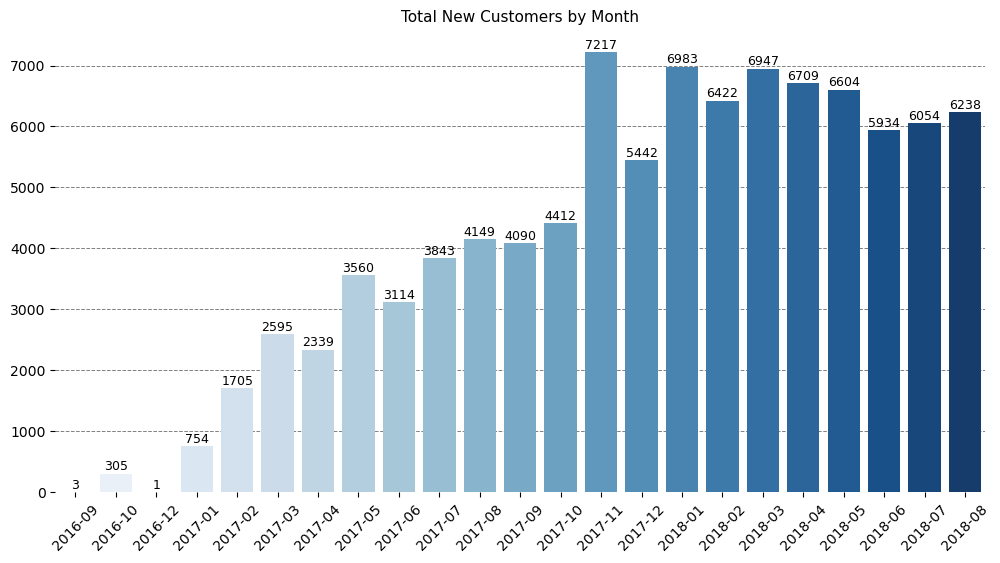

In [100]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=new_customer, x='first_purchase_month', y='count_customer', palette='Blues')

# Annotate the bars with the counts
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=9, color='black',
                xytext=(0, 5), textcoords='offset points')

# Remove the spines (the borders around the plot)
for spine in ax.spines.values():
    spine.set_visible(False)

# Add gridlines and ensure they are behind the bars
ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7, color='gray')
ax.set_axisbelow(True)  # Ensure gridlines are below the bars

# Customize the ticks and labels
plt.xticks(rotation=45)
plt.title('Total New Customers by Month', fontsize=11)
plt.xlabel('')
plt.ylabel('')

# Display the plot
plt.show()

##### Top Regions with the highest performance

In [108]:
#state, city
top_state = df.groupby('customer_state').agg(count_customer = ('customer_unique_id', 'nunique')).reset_index().sort_values(by = 'count_customer', ascending = False).head(10)

C:\Users\phuon\AppData\Local\Temp\ipykernel_60040\2198938094.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.barplot(data=top_state,


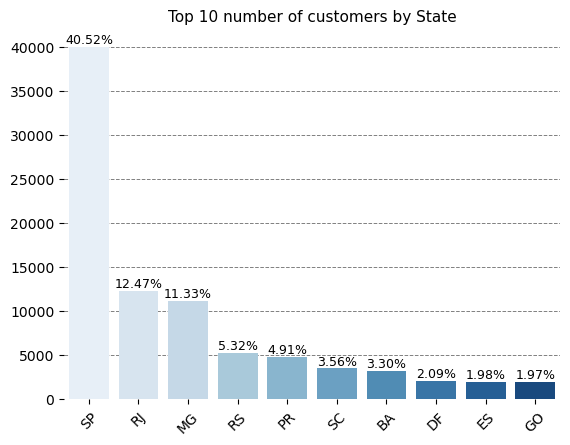

In [112]:
ax=sns.barplot(data=top_state,
            x='customer_state',
            y='count_customer',
            palette='Blues')
# Remove the spines (the borders around the plot)
for spine in ax.spines.values():
    spine.set_visible(False)

# Add gridlines and ensure they are behind the bars
ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7, color='gray')
ax.set_axisbelow(True)

n=df['customer_id'].nunique()
for p in ax.patches:
    ax.annotate(f'{100*int(p.get_height())/n:.2f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=9, color='black',
                xytext=(0, 5), textcoords='offset points')

plt.xticks(rotation=45)
plt.title('Top 10 number of customers by State', fontsize = 11)
plt.xlabel('')
plt.ylabel('')
plt.show()

In [114]:
top_city=df.groupby('customer_city').agg(count_customer=('customer_id','nunique')).reset_index()\
.sort_values(by='count_customer', ascending=False).head(5)

C:\Users\phuon\AppData\Local\Temp\ipykernel_60040\3057034545.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.barplot(data=top_city,


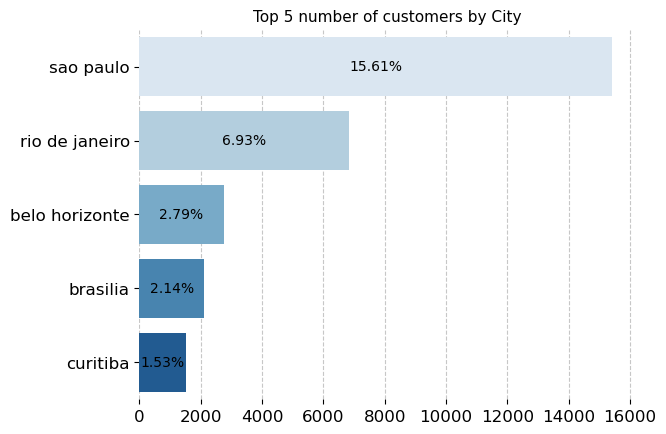

In [116]:
ax=sns.barplot(data=top_city,
            y='customer_city',
            x='count_customer',
            palette='Blues',
            zorder=3)
n=df['customer_id'].nunique()
for p in ax.patches:
    ax.text(p.get_width() / 2, p.get_y() + p.get_height() / 2,
            f'{100*int(p.get_width())/n:.2f}%',
            ha='center', va='center')

sns.despine(left=True, bottom=True)
plt.grid(True, axis='x', linestyle='--', alpha=0.7, zorder=0)
plt.title('Top 5 number of customers by City', fontsize = 11)
plt.xlabel('')
plt.ylabel('')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

##### Top best-selling products

In [119]:
#Number of orders for each product
#Average rating and number of reviews for each product
df.groupby('product_category_name_english').agg(count_order=('order_id','nunique')).reset_index().sort_values(by='count_order', ascending=False)

,product_category_name_english,count_order
8,bed_bath_table,9417
44,health_beauty,8836
66,sports_leisure,7720
16,computers_accessories,6689
40,furniture_decor,6449
...,...,...
4,arts_and_craftmanship,23
53,la_cuisine,13
12,cds_dvds_musicals,12
30,fashion_childrens_clothes,8


In [121]:
top_product_sao_paulo = df[df['customer_city'] == 'sao paulo'].groupby('product_category_name_english').agg(count_order = ('order_id', 'nunique')).reset_index().sort_values(by = 'count_order', ascending = False).head(5)

C:\Users\phuon\AppData\Local\Temp\ipykernel_60040\2103930299.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.barplot(data=top_product_sao_paulo,


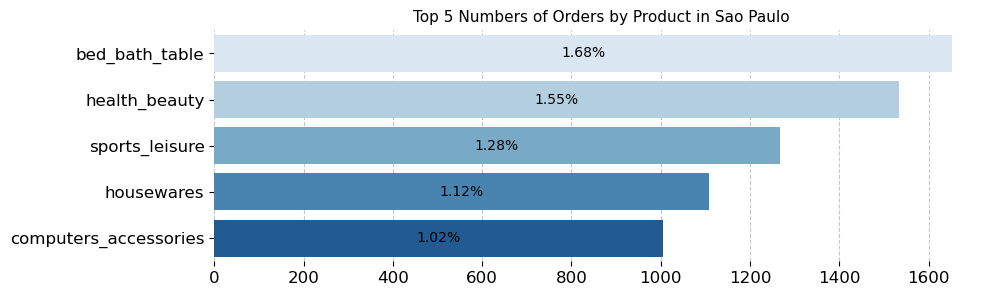

In [123]:
plt.figure(figsize=(10,3))
ax=sns.barplot(data=top_product_sao_paulo,
            y='product_category_name_english',
            x='count_order',
            palette='Blues',
            zorder=3)

n=df['order_id'].nunique()
for p in ax.patches:
    ax.text(p.get_width() / 2, p.get_y() + p.get_height() / 2,
            f'{100*int(p.get_width())/n:.2f}%',
            ha='center', va='center')


sns.despine(left=True, bottom=True)
plt.grid(True, axis='x', linestyle='--', alpha=0.7, zorder=0)
plt.title('Top 5 Numbers of Orders by Product in Sao Paulo', fontsize = 11)
plt.xlabel('')
plt.ylabel('')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

C:\Users\phuon\AppData\Local\Temp\ipykernel_60040\2061792401.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=top_product, y='product_category_name_english', x='count_order', palette='Blues', zorder=3)
C:\Users\phuon\AppData\Local\Temp\ipykernel_60040\2061792401.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=top_product, y='product_category_name_english', x='count_order', palette='Blues', zorder=3)
C:\Users\phuon\AppData\Local\Temp\ipykernel_60040\2061792401.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barp

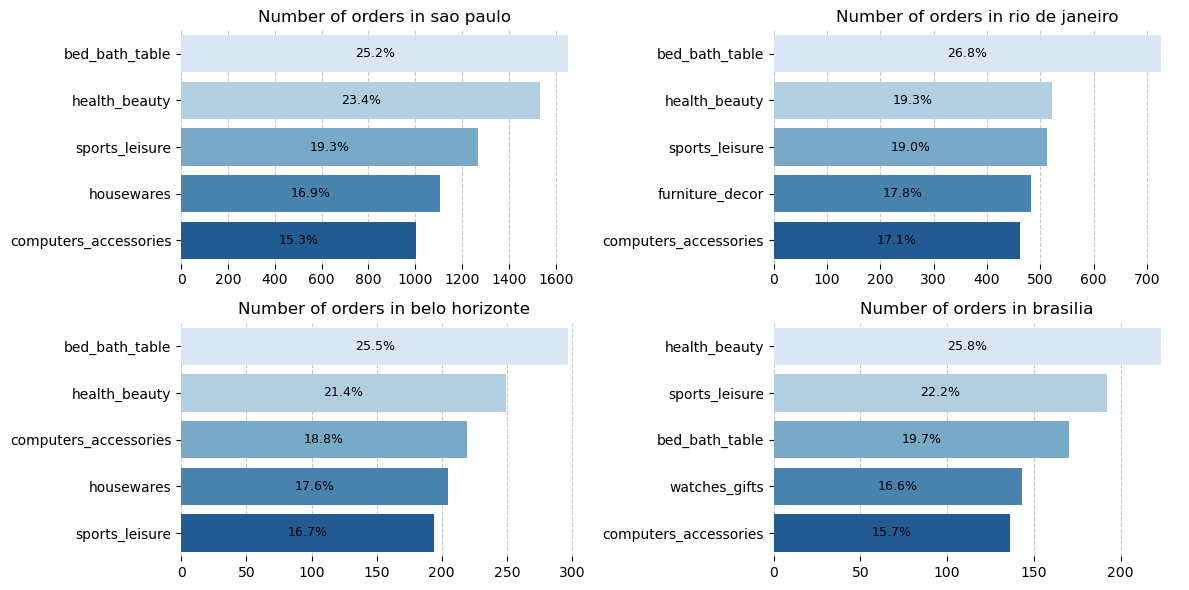

In [125]:
#Using a for loop to identify the best-selling products in the top 4 cities:
cities = ['sao paulo', 'rio de janeiro', 'belo horizonte', 'brasilia']
plt.figure(figsize = (12,6))

for i, city in enumerate(cities, 1):
    plt.subplot(2,2,i)

    # Get the top products for the city
    top_product = df[df['customer_city'] == city].groupby('product_category_name_english').agg(count_order=('order_id', 'nunique')).reset_index().sort_values(by='count_order', ascending=False).head(5)

    # Plot the bar chart
    ax = sns.barplot(data=top_product, y='product_category_name_english', x='count_order', palette='Blues', zorder=3)

    # Add percentage values to the bars
    total_orders = top_product['count_order'].sum()
    for p in ax.patches:
        width = p.get_width()
        percentage = (width / total_orders) * 100
        ax.annotate(f'{percentage:.1f}%',
                    (width / 2, p.get_y() + p.get_height() / 2),  # Center the text in the middle of the bar
                    ha='center', va='center', fontsize=9, color='black')

    # Customize the appearance of the plot
    sns.despine(left=True, bottom=True)
    ax.grid(True, axis='x', linestyle='--', alpha=0.7, zorder=0)  # Make sure the gridlines are behind the bars
    plt.xlabel('')
    plt.ylabel('')
    plt.title(f'Number of orders in {city}')

plt.tight_layout()
plt.show()

##### Top merchants with the highest performance: Based on Revenue and Customer Ratings

In [128]:
df_bed_bath_table = df[df['product_category_name_english'] == 'bed_bath_table']\
[['order_id', 'seller_id', 'payment_value', 'review_score']]
top_merchant = df_bed_bath_table.groupby('seller_id').agg(
    count_order=('order_id', 'nunique'),  # Changed to tuple format
    revenue=('payment_value', 'sum'),  # Changed to tuple format
    score=('review_score', 'mean')  # Changed to tuple format
).reset_index()

top_merchant[(top_merchant['count_order'] > top_merchant['count_order'].mean())
& (top_merchant['revenue'] > top_merchant['revenue'].mean())].sort_values(by = 'score', ascending = False).head(5).style.background_gradient(cmap='Blues')

,seller_id,count_order,revenue,score
49,33a6f4b1e7cdc205511e76ba1b6e0186,94,16317.530000,4.303279
53,37be5a7c751166fbc5f8ccba4119e043,268,64314.430000,4.282686
1,00ee68308b45bc5e2660cd833c3f81cc,113,34337.630000,4.273292
91,640e21a7d01df7614a3b4923e990d40c,116,16449.490000,4.268116
30,1e8b33f18b4f7598d87f5cbee2282cc2,123,26148.210000,4.260000


#### Retaining Existing Customers

##### Existing Customers Situation

In [ ]:
df_seleted_date=df[(df['order_purchase_timestamp']>='2018-01-01')
&(df['order_purchase_timestamp']<'2019-01-01')]
df_first_purchase=df_seleted_date.groupby('customer_unique_id')\
.agg(first_purchase_date=('order_purchase_timestamp','min')).reset_index()

df_first_purchase['first_purchase_date']=df_first_purchase['first_purchase_date'].dt.to_period('M')

df_seleted_date=pd.merge(df_seleted_date,df_first_purchase, on='customer_unique_id', how='left')
df_seleted_date['current_month']=df_seleted_date['order_purchase_timestamp'].dt.to_period('M')

In [133]:
from operator import attrgetter

# Convert the string dates to datetime objects for comparison
df_selected_date = df[(df['order_purchase_timestamp'] >= pd.to_datetime('2018-01-01')) & (df['order_purchase_timestamp'] < pd.to_datetime('2019-01-01'))]
df_first_purchase = df_selected_date.groupby('customer_unique_id')\
.agg(first_purchase_date = ('order_purchase_timestamp', 'min')).reset_index()
df_first_purchase['first_purchase_date'] = df_first_purchase['first_purchase_date'].dt.to_period('M')
df_selected_date = pd.merge(df_selected_date, df_first_purchase, on = 'customer_unique_id', how = 'left' )
df_selected_date['current month'] = df_selected_date['order_purchase_timestamp'].dt.to_period('M')
df_selected_date['delta month'] = (df_selected_date['current month'] - df_selected_date['first_purchase_date']).apply(attrgetter('n'))
df_selected_date[df_selected_date['delta month'] >0]

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,...,product_category_name_english,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,first_purchase_date,current month,delta month
58,003a7f59d7e08a9c61d9e2881fe6459c,1,a4d286543a67e29c930c99cbd7a55a8f,b410bdd36d5db7a65dcd42b7ead933b8,2018-08-22 11:49:46,119.00,15.28,f7838e5eeb3271df42376952e651e403,delivered,2018-08-19 12:51:50,...,housewares,71d5dd15707c2463aaf6bf469460337c,5.0,NaN,NaN,2018-08-28 00:00:00,2018-09-02 20:38:38,2018-02,2018-08,6
194,00c9d0257381c7e9ec13b4505f25b2cf,1,958cd4fc82ce0223c757f47bc9d67e23,abbf6046bbdf1028606a5bc7f00c99e7,2018-04-24 09:11:59,362.45,25.12,d14c86b99a98e85b5c256c081e3cea03,delivered,2018-04-18 08:57:18,...,auto,6d1a6be8fbfb1b9b4e0931a24cf0b914,5.0,NaN,NaN,2018-04-28 00:00:00,2018-04-29 17:29:01,2018-02,2018-04,2
198,00cee8a4dbb042385cbbd84699e78b2e,1,79e42c4fa2bde6e0c828d23c4fb7df35,6d66611d7c44cc30ce351abc49a68421,2018-07-26 04:25:10,59.90,9.17,450a869eb52446baa38f4beeecbc5843,delivered,2018-07-20 04:13:54,...,musical_instruments,a2937161bd6607b827771b6e47e9156e,5.0,Sim recomendo a loja,recebi o produto intacto,2018-07-26 00:00:00,2018-07-26 22:18:08,2018-06,2018-07,1
257,010efe60bdadc9261d1902f3c1dda5f3,1,fea7f0c147905a41ca324c0e3234a4c7,18a349e75d307f4b4cc646a691ed4216,2018-06-20 17:00:52,110.00,18.65,ac950cebc3bfe72c92a3768b6e8d3856,delivered,2018-06-07 16:46:09,...,computers_accessories,6ff0c3b38706728bce8d7f1390fba9be,4.0,Recomendo,"O produto atendeu as minhas expectativas, reco...",2018-06-16 00:00:00,2018-06-18 10:41:42,2018-04,2018-06,2
320,014bd8ca0827935402ac39f2751b2fcd,1,595fac2a385ac33a80bd5114aec74eb8,ef0ace09169ac090589d85746e3e036f,2018-05-15 13:11:00,119.90,15.72,9fa56e6eb804eb7f8c2d80a133c84546,delivered,2018-05-09 12:47:39,...,perfumery,b7705d1881618b1682a2c5cb0e358311,2.0,NaN,NaN,2018-05-17 00:00:00,2018-05-21 15:30:21,2018-01,2018-05,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63220,fdff9c6a7acb0e02d1cea8d18811e251,1,936a034fe3b07b7ae7c87fc8ceb0749d,6560211a19b47992c3666cc44a7e94c0,2018-06-21 14:31:59,249.00,9.90,eddc5297a74164ee82529b15e8357af7,delivered,2018-06-19 14:10:30,...,watches_gifts,ca60eff83a41f5db6c9eef93a0276829,5.0,NaN,NaN,2018-06-22 00:00:00,2018-06-22 22:25:28,2018-05,2018-06,1
63373,fe98cb0615a7611265d8955be5ca9497,1,e950f579a1170b4e385f734c5771e9f4,c5f7feb04a6a1fb3596322bfc3cf1917,2018-08-09 20:35:25,37.90,16.46,3b11d54278a86bfa191ef947e654c9cb,delivered,2018-08-01 17:13:52,...,furniture_decor,91178de0274f6a2d33925b62b2064b35,5.0,NaN,NaN,2018-08-11 00:00:00,2018-08-12 00:10:44,2018-07,2018-08,1
63376,fe9a7e2176f05d248141c7d1493f19bb,1,8cef0a48dd6a31a4da7683d1f35d8925,d94a40fd42351c259927028d163af842,2018-02-14 20:29:07,129.00,18.52,b71118b9a56b7671a08f7d317fe361c5,delivered,2018-02-08 20:12:55,...,housewares,8dc37fa7d6ac644151487effe48b6fad,5.0,NaN,NaN,2018-02-25 00:00:00,2018-02-27 10:38:06,2018-01,2018-02,1
63380,fe9d34568d9ac7651ff018def29da70f,1,ba74c6b75d2ad7503175809688d5a03c,7d13fca15225358621be4086e1eb0964,2018-05-17 02:57:34,178.99,41.40,419de035a0a31527733258cce22a7bff,delivered,2018-05-10 03:38:27,...,watches_gifts,ecff7af4e0cd8242cd8102a2d3572ef5,4.0,bom,"Recebi, tudo ótimo.",2018-06-05 00:00:00,2018-06-08 13:58:33,2018-03,2018-05,2


In [135]:
df_cohort = df_selected_date.groupby(['first_purchase_date', 'delta month']).agg(count_customer = ('customer_unique_id', 'nunique')).reset_index()

In [137]:
df_cohort_pivot = (
    df_cohort
    .pivot_table(index = 'first_purchase_date',
                 columns = 'delta month',
                 values = 'count_customer'))
df_cohort_pivot

delta month,0,1,2,3,4,5,6,7
first_purchase_date,,,,,,,,
2018-01,7120.0,28.0,28.0,25.0,22.0,15.0,14.0,17.0
2018-02,6509.0,26.0,26.0,22.0,19.0,14.0,13.0,NaN
2018-03,7042.0,34.0,22.0,23.0,11.0,9.0,NaN,NaN
2018-04,6793.0,40.0,22.0,18.0,11.0,NaN,NaN,NaN
2018-05,6689.0,36.0,20.0,15.0,NaN,NaN,NaN,NaN
2018-06,6006.0,25.0,17.0,NaN,NaN,NaN,NaN,NaN
2018-07,6109.0,32.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-08,6297.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [139]:
for col in df_cohort_pivot.columns[1:]:
  df_cohort_pivot[col] = df_cohort_pivot[col]/ df_cohort_pivot[0]
df_cohort_pivot[0] = 1
df_cohort_pivot

delta month,0,1,2,3,4,5,6,7
first_purchase_date,,,,,,,,
2018-01,1,0.003933,0.003933,0.003511,0.003090,0.002107,0.001966,0.002388
2018-02,1,0.003994,0.003994,0.003380,0.002919,0.002151,0.001997,NaN
2018-03,1,0.004828,0.003124,0.003266,0.001562,0.001278,NaN,NaN
2018-04,1,0.005888,0.003239,0.002650,0.001619,NaN,NaN,NaN
2018-05,1,0.005382,0.002990,0.002242,NaN,NaN,NaN,NaN
2018-06,1,0.004163,0.002831,NaN,NaN,NaN,NaN,NaN
2018-07,1,0.005238,NaN,NaN,NaN,NaN,NaN,NaN
2018-08,1,0.000159,NaN,NaN,NaN,NaN,NaN,NaN


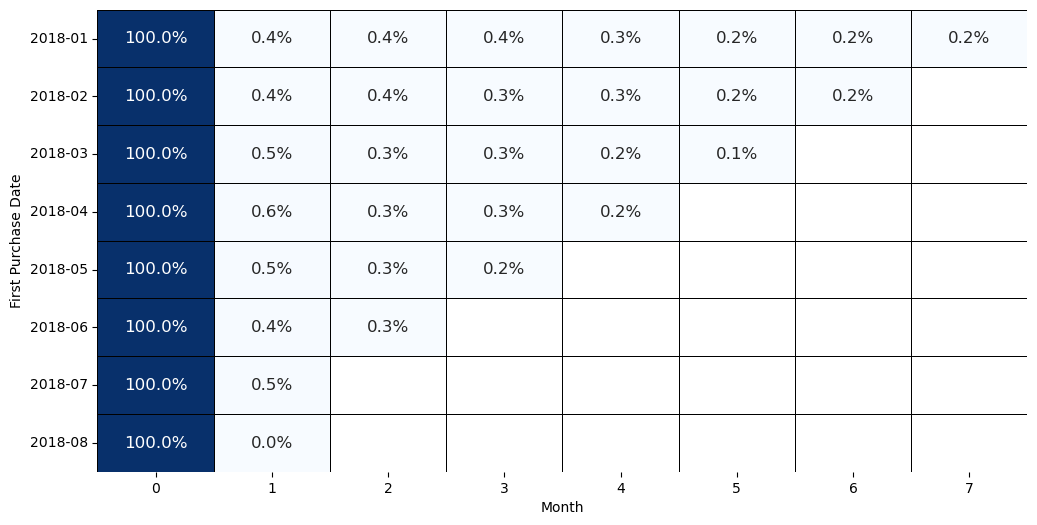

In [141]:
plt.figure(figsize=(12,6))
sns.heatmap(data=df_cohort_pivot,
            annot=True,
            fmt='.1%',
            cmap='Blues',
            cbar=False,
            linewidths=0.5,
            linecolor='black',
            linestyle='-',
            annot_kws={"size": 12}
            #square=True
            )
plt.ylabel('First Purchase Date')
plt.xlabel('Month')
plt.yticks(rotation=0)
plt.show()

##### How to imporve customer experience: Lead Time Performance

In [155]:
#How does delivery time affect customer satisfaction?
#What is the on-time and late delivery rate?
#Has the delivery time improved over the years
df['dispatch_time'] = (df['order_delivered_carrier_date'] - df['order_approved_at']).dt.days
df['delivery_time'] = (df['order_delivered_customer_date'] - df['order_delivered_carrier_date']).dt.days
df['actual vs estimated dispatch time'] = (df['order_delivered_carrier_date'] - df['shipping_limit_date']).dt.days
df['actual vs estimated delivery time'] = (df['order_delivered_customer_date'] - df['order_estimated_delivery_date']).dt.days

In [157]:
df.head(2)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,...,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,dispatch_time,delivery_time,actual vs estimated dispatch time,actual vs estimated delivery time
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,...,97ca439bc427b48bc1cd7177abe71365,5.0,NaN,"Perfeito, produto entregue antes do combinado.",2017-09-21 00:00:00,2017-09-22 10:57:03,6.0,1.0,0.0,-9
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,...,7b07bacd811c4117b742569b04ce3580,4.0,NaN,NaN,2017-05-13 00:00:00,2017-05-15 11:34:13,8.0,8.0,1.0,-3


In [159]:
def ontime_or_late(x):
  if x > 0:
    return 'Late'
  else:
    return 'On time'
df['actual vs estimated dispatch time'] = df['actual vs estimated dispatch time'].apply(ontime_or_late)

In [161]:
df['actual vs estimated delivery time'] = df['actual vs estimated delivery time'].apply(ontime_or_late)

In [163]:
df.head(2)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,...,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,dispatch_time,delivery_time,actual vs estimated dispatch time,actual vs estimated delivery time
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,...,97ca439bc427b48bc1cd7177abe71365,5.0,NaN,"Perfeito, produto entregue antes do combinado.",2017-09-21 00:00:00,2017-09-22 10:57:03,6.0,1.0,On time,On time
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,...,7b07bacd811c4117b742569b04ce3580,4.0,NaN,NaN,2017-05-13 00:00:00,2017-05-15 11:34:13,8.0,8.0,Late,On time


In [165]:
#Does delivery time affect customer satisfaction?
df['total time'] = df['dispatch_time'] + df['delivery_time']

C:\Users\phuon\AppData\Local\Temp\ipykernel_60040\3809462041.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = df[df['total time']<df['total time'].quantile(0.95)],


<Axes: xlabel='review_score', ylabel='total time'>

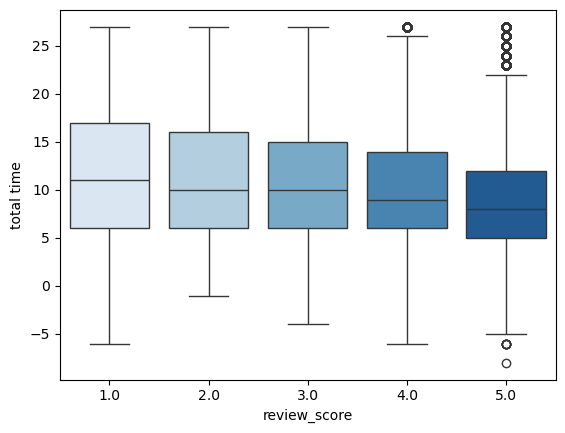

In [167]:
sns.boxplot(data = df[df['total time']<df['total time'].quantile(0.95)],
            x = 'review_score',
            y = 'total time',
            palette='Blues')

In [171]:
#actual vs estimated dispatch time:
actual_vs_estimated_dispatch_time = df.groupby('actual vs estimated dispatch time').agg(count = ('order_id', 'nunique')).reset_index()
actual_vs_estimated_dispatch_time

,actual vs estimated dispatch time,count
0,Late,4432
1,On time,94238


C:\Users\phuon\AppData\Local\Temp\ipykernel_60040\4288269351.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=actual_vs_estimated_dispatch_time,


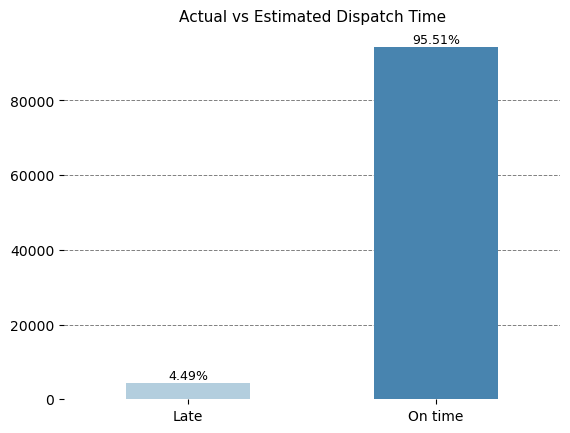

In [177]:
ax = sns.barplot(data=actual_vs_estimated_dispatch_time,
                 x='actual vs estimated dispatch time',
                 y='count',
                 palette='Blues', 
                 width = 0.5)

n = df['order_id'].nunique()

# Annotate each bar with a percentage
for p in ax.patches:
    ax.annotate(f'{100 * int(p.get_height()) / n:.2f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=9, color='black',
                xytext=(0, 5), textcoords='offset points')

# Remove the spines (the borders around the plot)
for spine in ax.spines.values():
    spine.set_visible(False)

# Add gridlines and ensure they are behind the bars
ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7, color='gray')
ax.set_axisbelow(True)  # Ensure gridlines are below the bars

# Set plot title and labels
plt.title('Actual vs Estimated Dispatch Time', fontsize = 11)
plt.xlabel('')
plt.ylabel('')

# Display the plot
plt.show()

In [179]:
#actual vs estimated delivery time:
actual_vs_estimated_delivery_time = df.groupby('actual vs estimated delivery time').agg(count = ('order_id', 'nunique')).reset_index()

C:\Users\phuon\AppData\Local\Temp\ipykernel_60040\751905995.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data = actual_vs_estimated_delivery_time,


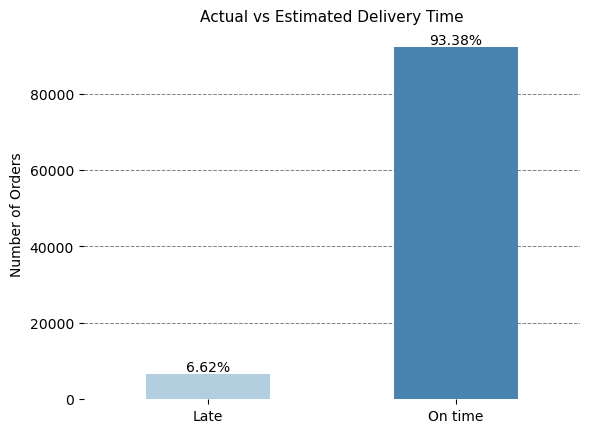

In [183]:
#Draw bar chart:
ax = sns.barplot(data = actual_vs_estimated_delivery_time,
            x = 'actual vs estimated delivery time',
            y = 'count',
            palette='Blues', 
            width = 0.5)

n = df['order_id'].nunique()
for p in ax.patches:
    percentage = 100 * p.get_height() / n  # Calculate percentage
    ax.annotate(f"{percentage:.2f}%",  # Format the percentage with 2 decimal places
                (p.get_x() + p.get_width() / 2, p.get_height()),  # Position above each bar
                ha='center', va='bottom',  # Center alignment for horizontal and bottom alignment for vertical
                fontsize=10, color='black')
# Remove the spines (the borders around the plot)
for spine in ax.spines.values():
    spine.set_visible(False)

# Add gridlines and ensure they are behind the bars
ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7, color='gray')
ax.set_axisbelow(True)  # Ensure gridlines are below the bars

# Add plot title and labels
plt.title('Actual vs Estimated Delivery Time', fontsize = 11)
plt.xlabel('')
plt.ylabel('Number of Orders', fontsize = 10)

# Display the plot
plt.show()

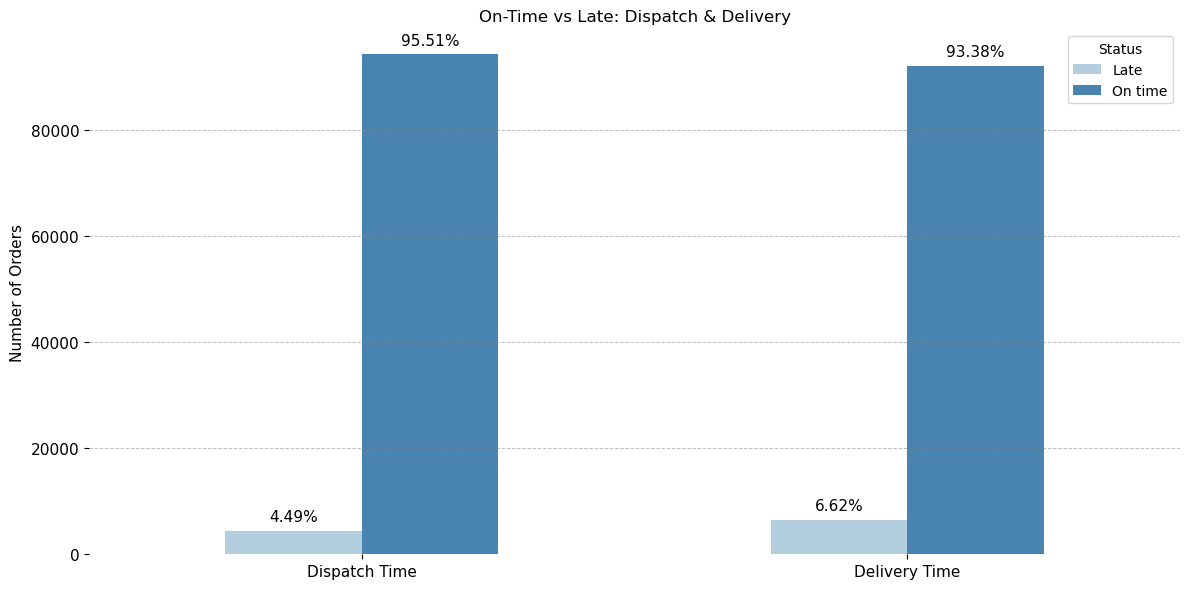

In [185]:
#Create data for actual_vs_estimated_dispatch_time and actual_vs_estimated_delivery_time
#Group by the Dispatch Time status
actual_vs_estimated_dispatch_time = df.groupby('actual vs estimated dispatch time').agg(count=('order_id', 'nunique')).reset_index()
actual_vs_estimated_dispatch_time['Type'] = 'Dispatch Time'

#Group by the Delivery Time status
actual_vs_estimated_delivery_time = df.groupby('actual vs estimated delivery time').agg(count=('order_id', 'nunique')).reset_index()
actual_vs_estimated_delivery_time['Type'] = 'Delivery Time'

#Combine the data of Dispatch Time and Delivery Time.
dispatch_data = actual_vs_estimated_dispatch_time[['actual vs estimated dispatch time', 'count', 'Type']].rename(columns={'actual vs estimated dispatch time': 'Status'})
delivery_data = actual_vs_estimated_delivery_time[['actual vs estimated delivery time', 'count', 'Type']].rename(columns={'actual vs estimated delivery time': 'Status'})

#Combine the data
combined_data = pd.concat([dispatch_data, delivery_data])


# Draw Grouped Bar Chart
plt.figure(figsize=(12,6))
ax = sns.barplot(data=combined_data,
                 x='Type',  # Status: Dispatch Time hoặc Delivery Time
                 y='count',  # The number of orders
                 hue='Status',  # Classify Dispatch Time và Delivery Time
                 palette='Blues',
                 dodge=True, #Split the columns for Dispatch Time and Delivery Time.
                width=0.5)

# Annotate the bars with the counts
n = df['order_id'].nunique()
for p in ax.patches:
    percentage = 100 * int(p.get_height()) / n
    if percentage > 0:
        ax.annotate(f'{percentage:.2f}%',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    fontsize= 11, color='black',
                    xytext=(0, 10), textcoords='offset points')

for spine in ax.spines.values():
    spine.set_visible(False)

# Add gridline
ax.grid(True, axis='y', linestyle='--', linewidth=0.7, color='gray', alpha=0.5)

plt.title('On-Time vs Late: Dispatch & Delivery', fontsize = 12)
plt.xlabel('')
plt.ylabel('Number of Orders', fontsize=11)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.tight_layout()
plt.show()

In [187]:
#Evaluate whether delivery times have improved over the years
df['year'] = df['order_purchase_timestamp'].dt.year

In [189]:
df.groupby('year').agg(mean = ('total time', 'mean')).reset_index()

,year,mean
0,2016,19.857550
1,2017,11.684832
2,2018,10.816338


C:\Users\phuon\AppData\Local\Temp\ipykernel_60040\1443130308.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data = df.groupby('year').agg(mean = ('total time', 'mean')).reset_index(),


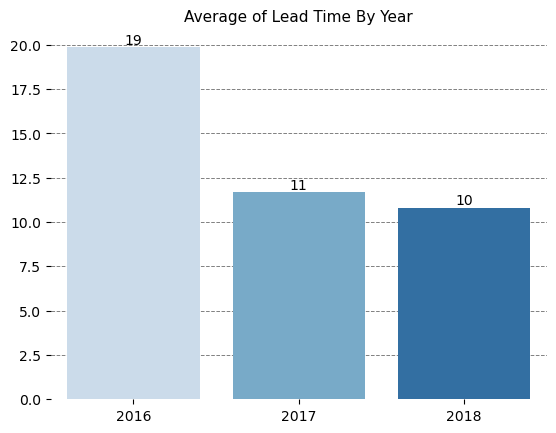

In [191]:
ax = sns.barplot(data = df.groupby('year').agg(mean = ('total time', 'mean')).reset_index(),
            x = 'year',
            y = 'mean',
            palette='Blues',)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',  # Format the number as an integer
                (p.get_x() + p.get_width() / 2., p.get_height()),  # Position at the top of the bar
                ha='center', va='bottom',  # Center alignment
                fontsize=10, color='black',)  # Slight offset above the bar
# Remove the spines (the borders around the plot)
for spine in ax.spines.values():
    spine.set_visible(False)

# Add gridlines and ensure they are behind the bars
ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7, color='gray')
ax.set_axisbelow(True)  # Ensure gridlines are below the bars

plt.title('Average of Lead Time By Year', fontsize = 11 )
plt.xlabel('')
plt.ylabel('')
plt.show()

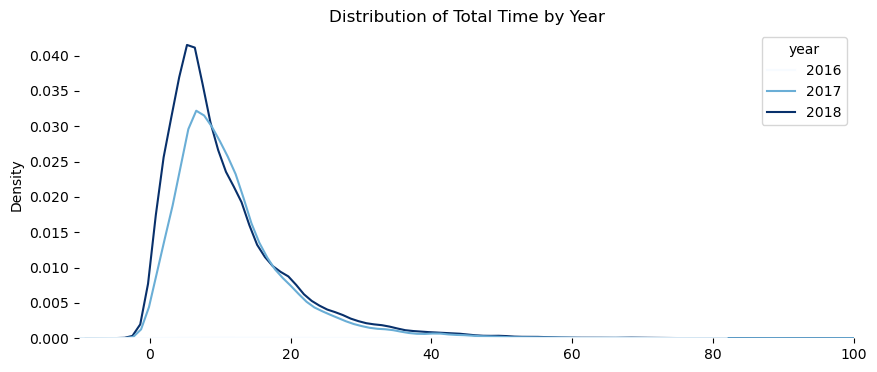

In [193]:
plt.figure(figsize=(10,4))
sns.kdeplot(data=df,
            x='total time',
            hue='year',
            palette='Blues')

plt.xlim(-10, 100)
plt.title('Distribution of Total Time by Year', fontsize = 12)
plt.xlabel('')
plt.ylabel( 'Density',fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Remove spines:
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(False)
plt.show()

##### Enhance Dispatch Time (Sellers)

In [195]:
#Average Dispatch time for an order by each seller's region
avg_dispatch_time = df.groupby('seller_state').agg(avg_dispatch_time = ('dispatch_time', 'mean')).reset_index()\
.sort_values(by = 'avg_dispatch_time', ascending = False)
avg_dispatch_time

,seller_state,avg_dispatch_time
7,MA,4.075795
17,RN,3.375000
9,MS,3.350000
11,PA,2.750000
3,CE,2.676471
1,AM,2.666667
15,PR,2.591200
2,BA,2.551170
19,RS,2.510177
10,MT,2.374150


C:\Users\phuon\AppData\Local\Temp\ipykernel_60040\2203669835.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=avg_dispatch_time,


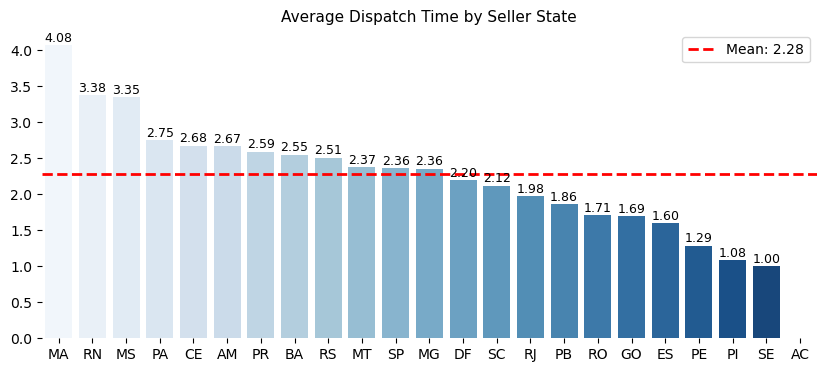

In [197]:
# Draw barplot
plt.figure(figsize=(10, 4))
ax = sns.barplot(data=avg_dispatch_time,
                 x='seller_state',
                 y='avg_dispatch_time',
                 palette='Blues')

# Annotate the bars with the values
for p in ax.patches:
    ax.annotate(f'{(p.get_height()):.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=9, color='black',
                xytext=(0, 5), textcoords='offset points')

for spine in ax.spines.values():
    spine.set_visible(False)

#Calculate the average value and plot the average line
mean_value = avg_dispatch_time['avg_dispatch_time'].mean()
plt.axhline(mean_value, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_value:.2f}')
plt.title('Average Dispatch Time by Seller State', fontsize = 11)
plt.xlabel('')
plt.ylabel('')
plt.legend()
plt.show()

C:\Users\phuon\AppData\Local\Temp\ipykernel_60040\760300701.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = df[df['seller_state'].isin(['MA', 'RN', 'MS'])],


<Axes: xlabel='seller_state', ylabel='dispatch_time'>

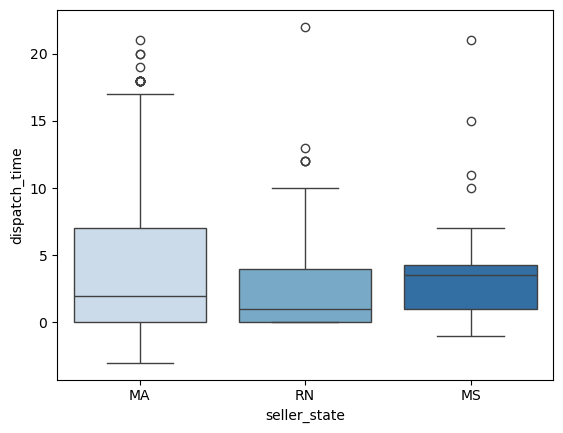

In [199]:
#Zoom in on the three states: MA, RN, MS to check why the dispatch time is so high
df[df['seller_state'].isin(['MA', 'RN', 'MS'])]
sns.boxplot(data = df[df['seller_state'].isin(['MA', 'RN', 'MS'])],
            x = 'seller_state',
            y = 'dispatch_time',
            palette = 'Blues')

In [201]:
df[(df['seller_state'] == 'MA') & (df['dispatch_time'] > 15)][['product_category_name_english', 'seller_id']].value_counts()

product_category_name_english  seller_id                       
health_beauty                  06a2c3af7b3aee5d69171b0e14f0ee87    21
Name: count, dtype: int64

In [203]:
df[(df['seller_state'] == 'RN') & (df['dispatch_time'] > 10)][['product_category_name_english', 'seller_id']].value_counts()

product_category_name_english  seller_id                       
furniture_decor                02d35243ea2e497335cd0f076b45675d    5
Name: count, dtype: int64

In [205]:
df[(df['seller_state'] == 'MS') & (df['dispatch_time'] > 10)][['product_category_name_english', 'seller_id']].value_counts()

product_category_name_english  seller_id                       
auto                           9c068d10aca38e85c50202e17b4a7e88    2
health_beauty                  b1fecf4da1fa2689bccffa0121953643    1
Name: count, dtype: int64

In [207]:
#Identify which sellers are in a warning status regarding dispatch time
sellers = df[['order_id', 'seller_id', 'payment_value']].drop_duplicates().groupby('seller_id').agg(
    count_order=('order_id', 'nunique'),
    revenue=('payment_value', 'sum')
).reset_index()

# Aggregate data for sellers with late orders
sellers_late_time = df[df['actual vs estimated dispatch time'] == 'Late'].groupby('seller_id').agg(
    late_count=('order_id', 'nunique')
).reset_index()

sellers = df.groupby('seller_id').agg(
    count_order=('order_id', 'nunique'),
    revenue=('payment_value', 'sum')
).reset_index()

# Aggregate data for sellers with late orders
sellers_late_time = df[df['actual vs estimated dispatch time'] == 'Late'].groupby('seller_id').agg(
    late_count=('order_id', 'nunique')
).reset_index()

# Merge the two datasets
sellers_merge = pd.merge(sellers, sellers_late_time, on='seller_id', how='left').fillna(0)
sellers_merge['Late Rate'] = 100 * sellers_merge['late_count']/ sellers_merge['count_order']

In [209]:
sellers_merge['count_order'].mean()

32.31340872374798

In [211]:
# Filter the merged dataframe, instead of the original 'sellers' dataframe
seller_late = sellers_merge[(sellers_merge['count_order'] >= sellers_merge['count_order'].mean()) & (sellers_merge['revenue']>= sellers_merge['revenue'].mean())]

# You can now sort by 'Late Rate' as it exists in the filtered 'sellers_merge' dataframe
seller_late = seller_late.reset_index().sort_values(by = 'Late Rate', ascending = False).head(10)
seller_late[['seller_id', 'count_order', 'revenue', 'Late Rate']].style.background_gradient(cmap = 'Blues')

,seller_id,count_order,revenue,Late Rate
243,835f0f7810c76831d6c7d24c7a646d4d,44,7722.230000,59.090909
151,54965bbe3e4f07ae045b90b0b8541f52,78,15560.610000,42.307692
63,1da366cade6d8276e7d8beea7af5d4bf,43,10268.920000,41.860465
303,a49928bcdf77c55c6d6e05e09a9b4ca5,98,12521.220000,40.816327
306,a7f13822ceb966b076af67121f87b063,75,18984.150000,40.000000
255,88460e8ebdecbfecb5f9601833981930,248,56514.990000,39.516129
316,ad781527c93d00d89a11eecd9dcad7c1,44,10094.610000,31.818182
353,c60b801f2d52c7f7f91de00870882a75,41,14205.030000,31.707317
74,23613d49c3ac2bd302259e55c06c050c,70,8924.270000,30.000000
267,8e6cc767478edae941d9bd9eb778d77a,106,10154.070000,28.301887


##### Enhance Delivery Time (Customers)

In [214]:
#Average delivery time in each customer region.
avg_delivery_time = df.groupby('customer_state').agg(avg_delivery_time = ('delivery_time', 'mean')).reset_index()\
.sort_values(by = 'avg_delivery_time', ascending = False)
avg_delivery_time

,customer_state,avg_delivery_time
21,RR,24.784314
3,AP,24.048193
2,AM,23.450292
1,AL,20.617778
13,PA,20.054905
9,MA,17.586412
24,SE,17.426768
5,CE,17.242051
0,AC,17.115789
14,PB,16.698738


C:\Users\phuon\AppData\Local\Temp\ipykernel_60040\1884771449.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=avg_delivery_time,


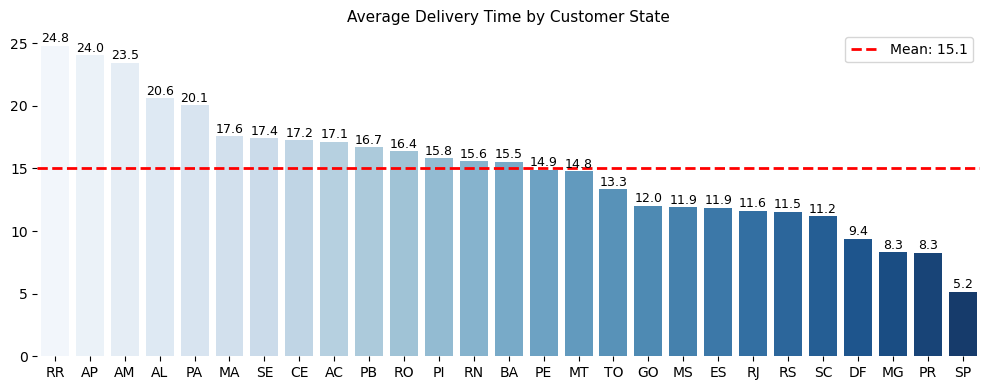

In [216]:
#Draw bar plot for avg_delivery_time:
plt.figure(figsize=(10, 4))
ax = sns.barplot(data=avg_delivery_time,
                 x='customer_state',
                 y='avg_delivery_time',
                 palette='Blues')

# Annotate the bars with the values
for p in ax.patches:
    ax.annotate(f'{(p.get_height()):.1f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=9, color='black',
                xytext=(0, 5), textcoords='offset points')

for spine in ax.spines.values():
    spine.set_visible(False)

#Calculate the average value and plot the average line
mean_value = avg_delivery_time['avg_delivery_time'].mean()
plt.axhline(mean_value, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_value:.1f}')
plt.title('Average Delivery Time by Customer State', fontsize = 11)
plt.legend()
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.show()

In [218]:
#Ratio of Late vs. On-time deliveries for each region."
ontime_late_customer_state = (df.groupby('customer_state')['actual vs estimated delivery time'].value_counts(normalize = True)*100).reset_index()
ontime_late_customer_state['proportion'] = ontime_late_customer_state['proportion'].round(2)
ontime_late_customer_state = ontime_late_customer_state.sort_values(by = 'proportion')

In [220]:
ontime_late_customer_state.head(2)

,customer_state,actual vs estimated delivery time,proportion
5,AM,Late,2.92
1,AC,Late,3.16


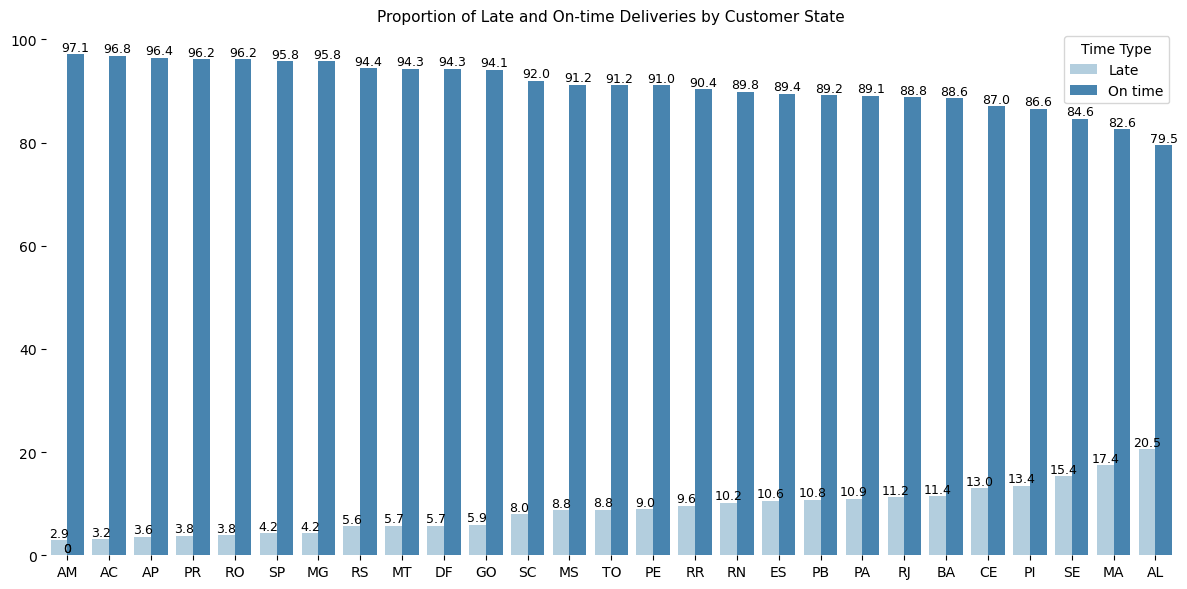

In [226]:
# Draw the barplot
plt.figure(figsize=(12,6))
ax = sns.barplot(data=ontime_late_customer_state,
                 x='customer_state',
                 y='proportion',
                 hue='actual vs estimated delivery time',
                 palette='Blues')

# Annotate each bar with its height
for p in ax.patches:
    ax.annotate(
        str(round(p.get_height(), 1)),  # Round to 1 decimal point for better display
        (p.get_x() + p.get_width() / 2., p.get_height()),  # Center of each bar
        ha="center", va="center", fontsize=9, color="black", xytext=(0, 5),
        textcoords="offset points"
    )

for spine in ax.spines.values():
    spine.set_visible(False)

plt.legend(title="Time Type")
plt.title('Proportion of Late and On-time Deliveries by Customer State', fontsize = 11)
plt.ylabel("")
plt.xlabel("")
plt.tight_layout()
plt.show()

##### Enhance Payment Processing

###### Which payment method has the lowest success rate?

In [230]:
df.groupby('payment_type')['review_score'].mean()

payment_type
boleto         4.025128
credit_card    4.033232
debit_card     4.156176
voucher        4.008355
Name: review_score, dtype: float64

In [232]:
payment_method = df[['order_id', 'payment_type', 'payment_value']].drop_duplicates()\
.groupby('payment_type').agg(count_order = ('order_id', 'nunique'), revenue = ('payment_value', 'sum')).reset_index()

C:\Users\phuon\AppData\Local\Temp\ipykernel_60040\3127970030.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=payment_method,


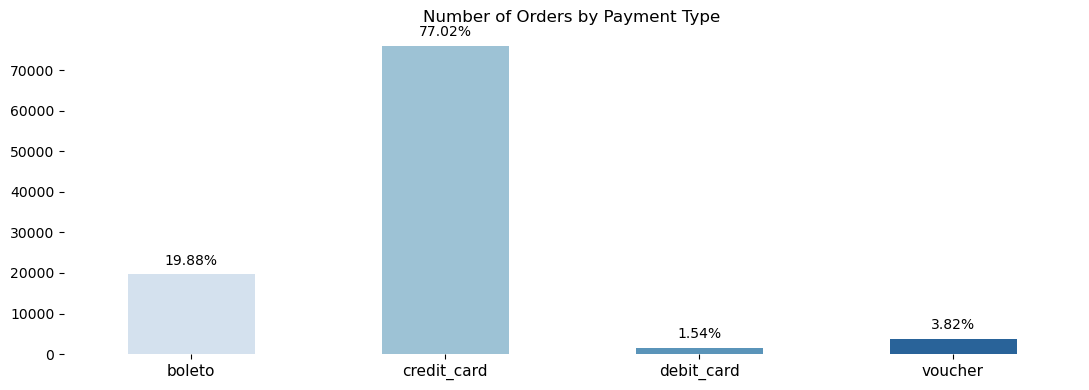

In [234]:
# Draw barplot for payment_method
plt.figure(figsize=(11, 4))
ax = sns.barplot(data=payment_method,
                 x='payment_type',
                 y='count_order',
                 palette='Blues',
                 width = 0.5)

# Annotate each bar with its percentage
n = df['order_id'].nunique()
for p in ax.patches:
    ax.annotate(f'{100 * int(p.get_height()) / n:.2f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 10),
                textcoords='offset points')

for spine in ax.spines.values():
    spine.set_visible(False)

plt.title('Number of Orders by Payment Type', fontsize = 12)
plt.xlabel('')
plt.xticks(fontsize=11)
plt.ylabel('')

plt.tight_layout()  # Improve layout
plt.show()

In [236]:
#Success and unsuccessful payment rates
df['order_status'].value_counts()

order_status
delivered      115038
shipped          1244
canceled          566
processing        375
invoiced          371
unavailable         7
approved            3
Name: count, dtype: int64

In [238]:
def payment_status(x):
  if x in ['unavailable', 'canceled']:
    return 'unsuccess'
  else:
    return 'success'
df['payment_status'] = df['order_status'].apply(payment_status)

In [240]:
df.head(2)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,...,review_comment_message,review_creation_date,review_answer_timestamp,dispatch_time,delivery_time,actual vs estimated dispatch time,actual vs estimated delivery time,total time,year,payment_status
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,...,"Perfeito, produto entregue antes do combinado.",2017-09-21 00:00:00,2017-09-22 10:57:03,6.0,1.0,On time,On time,7.0,2017,success
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,...,NaN,2017-05-13 00:00:00,2017-05-15 11:34:13,8.0,8.0,Late,On time,16.0,2017,success


In [242]:
payment_failure = df[df['payment_status'] == 'unsuccess'].groupby('payment_type').agg(count_failure = ('order_id', 'nunique')).reset_index()

In [244]:
payment_rate = pd.merge(payment_method, payment_failure, on = 'payment_type', how = 'left')
payment_rate

,payment_type,count_order,revenue,count_failure
0,boleto,19614,2842240.16,79
1,credit_card,75991,12434000.78,377
2,debit_card,1521,215105.73,6
3,voucher,3766,337388.70,21


In [246]:
# Calculate 'failure_rate'
payment_rate['failure_rate'] = 100 * payment_rate['count_failure'] / payment_rate['count_order']

# Select desired columns and apply background gradient
payment_rate = payment_rate[['payment_type', 'count_order', 'revenue', 'failure_rate']].style.background_gradient(cmap = 'Blues')
payment_rate

,payment_type,count_order,revenue,failure_rate
0,boleto,19614,2842240.160000,0.402774
1,credit_card,75991,12434000.780000,0.496111
2,debit_card,1521,215105.730000,0.394477
3,voucher,3766,337388.700000,0.557621


### Opportunity 2:Increase Order Frequency

#### Orders Quantity Distribution

In [250]:
#Number of orders by day
df['date'] = df['order_purchase_timestamp'].dt.date

In [252]:
df.groupby('date').agg(count_order = ('order_id', 'nunique')).reset_index()

,date,count_order
0,2016-09-04,1
1,2016-09-05,1
2,2016-09-15,1
3,2016-10-02,1
4,2016-10-03,8
...,...,...
611,2018-08-26,73
612,2018-08-27,66
613,2018-08-28,39
614,2018-08-29,11


C:\Users\phuon\AppData\Local\Temp\ipykernel_60040\2612887250.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df.groupby('date').agg(count_order=('order_id', 'nunique')).reset_index(),


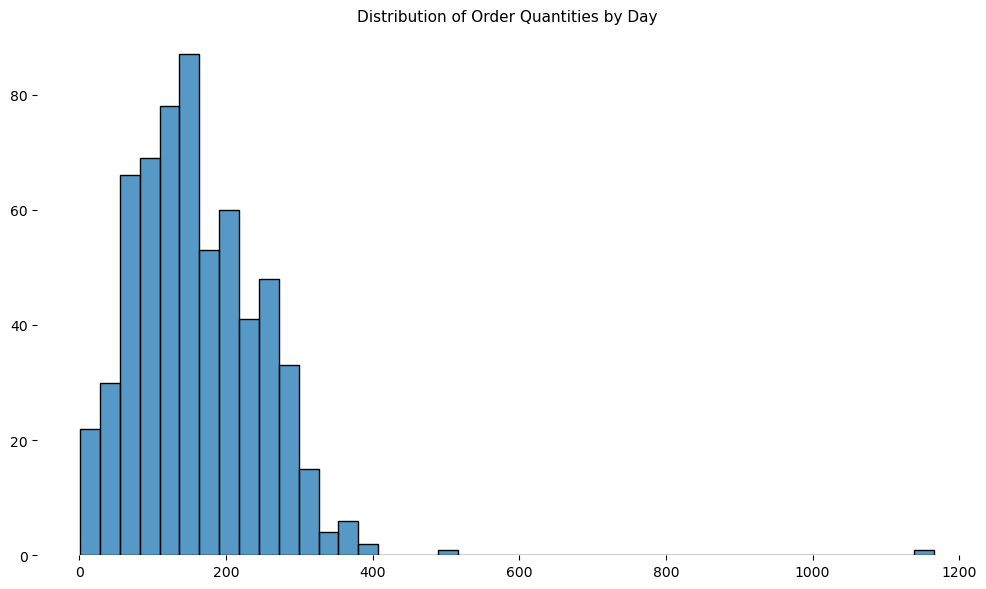

In [254]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df.groupby('date').agg(count_order=('order_id', 'nunique')).reset_index(),
             x='count_order',
             palette='Blues')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

plt.title('Distribution of Order Quantities by Day', fontsize = 11)
plt.xlabel('')
plt.ylabel('')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()

#### The time frame when the number of orders tends to be high

In [258]:
#Which day of the week? Which hour of the week?
df['day_of_week'] = df['order_purchase_timestamp'].dt.day_of_week
df['day_name'] = df['order_purchase_timestamp'].dt.strftime('%a')
df['hour'] = df['order_purchase_timestamp'].dt.hour

In [260]:
order_frequency = df.groupby(['day_name', 'hour', 'day_of_week']).agg(count_order = ('order_id', 'nunique')).reset_index()

In [262]:
order_frequency = order_frequency.set_index('day_name')

In [264]:
order_frequency_pivot = (
    order_frequency
    .pivot_table(index = ['day_name', 'day_of_week'],
                 columns = 'hour',
                 values = 'count_order'))
order_frequency_pivot = order_frequency_pivot.sort_values(by = 'day_of_week').reset_index().drop(columns = 'day_of_week')
order_frequency_pivot = order_frequency_pivot.set_index('day_name')

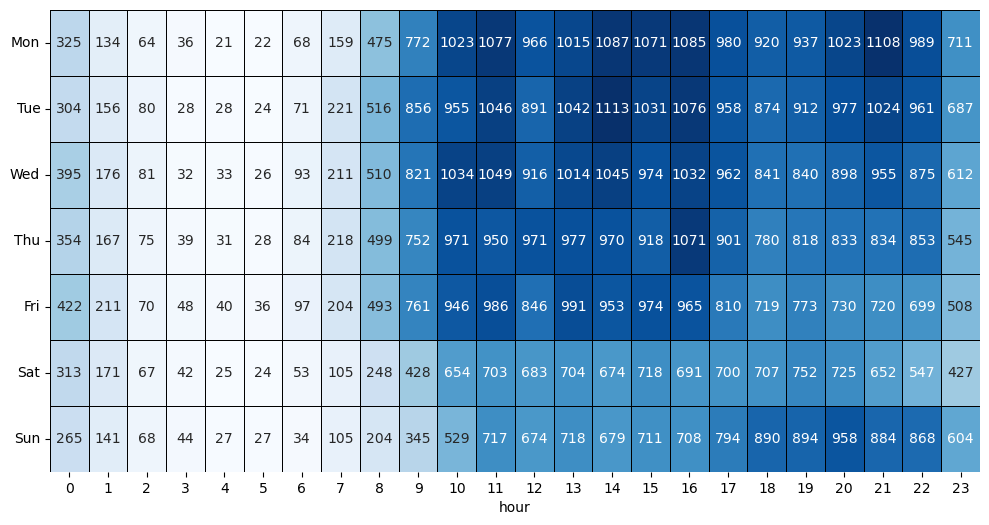

In [266]:
plt.figure(figsize=(12,6))
sns.heatmap(data=order_frequency_pivot,
             fmt='.0f',
            annot=True,
            cmap='Blues',
            cbar=False,
            linewidths=0.5,
            linecolor='black',
            linestyle='-',
            annot_kws={"size": 10})
plt.ylabel('')
plt.xlabel('hour')
plt.yticks(rotation=0)
plt.show()

#### Customer Segmentation Analysis: Analyze customers by RFM (Recency, Frequency, Monetary)

In [271]:
recency_cust = df.groupby('customer_unique_id').agg(max_order_purchase_timestamp = ('order_purchase_timestamp', 'max')).reset_index()
recency_cust['recency'] = (pd.to_datetime('2018-09-01')-recency_cust['max_order_purchase_timestamp']).dt.days
recency_cust

,customer_unique_id,max_order_purchase_timestamp,recency
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,113
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,116
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,539
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,323
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,290
...,...,...,...
95415,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08 21:00:36,449
95416,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:07:56,264
95417,ffff371b4d645b6ecea244b27531430a,2017-02-07 15:49:16,570
95418,ffff5962728ec6157033ef9805bacc48,2018-05-02 15:17:41,121


In [273]:
fluency_cust = df.groupby('customer_unique_id').agg(frequency = ('order_id', 'nunique')).reset_index()
fluency_cust

,customer_unique_id,frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1
...,...,...
95415,fffcf5a5ff07b0908bd4e2dbc735a684,1
95416,fffea47cd6d3cc0a88bd621562a9d061,1
95417,ffff371b4d645b6ecea244b27531430a,1
95418,ffff5962728ec6157033ef9805bacc48,1


In [275]:
monetary_cust = df[['order_id', 'customer_unique_id', 'payment_value']].drop_duplicates().groupby('customer_unique_id').agg(monetary = ('payment_value', 'sum')).reset_index()
monetary_cust

,customer_unique_id,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19
2,0000f46a3911fa3c0805444483337064,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,43.62
4,0004aac84e0df4da2b147fca70cf8255,196.89
...,...,...
95415,fffcf5a5ff07b0908bd4e2dbc735a684,2067.42
95416,fffea47cd6d3cc0a88bd621562a9d061,84.58
95417,ffff371b4d645b6ecea244b27531430a,112.46
95418,ffff5962728ec6157033ef9805bacc48,133.69


In [277]:
rf = pd.merge(recency_cust, fluency_cust, on = 'customer_unique_id', how = 'inner')
rfm = pd.merge(rf, monetary_cust, on = 'customer_unique_id', how = 'inner')
rfm

,customer_unique_id,max_order_purchase_timestamp,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,113,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,116,1,27.19
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,539,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,323,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,290,1,196.89
...,...,...,...,...,...
95415,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08 21:00:36,449,1,2067.42
95416,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:07:56,264,1,84.58
95417,ffff371b4d645b6ecea244b27531430a,2017-02-07 15:49:16,570,1,112.46
95418,ffff5962728ec6157033ef9805bacc48,2018-05-02 15:17:41,121,1,133.69


C:\Users\phuon\AppData\Local\Temp\ipykernel_60040\2343093996.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.histplot(data=rfm,


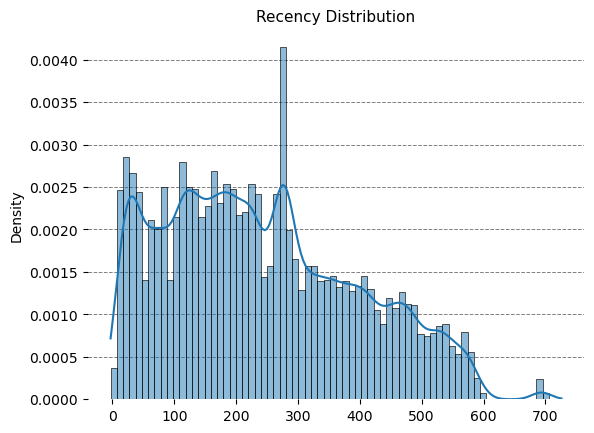

In [279]:
# Plot the histogram with kde
ax = sns.histplot(data=rfm,
                  x='recency',
                  kde=True,
                  stat='density',
                  palette = 'Blues')

# Remove the spines (the borders around the plot)
for spine in ax.spines.values():
    spine.set_visible(False)

# Add gridlines and ensure they are behind the bars
ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7, color='gray')
ax.set_axisbelow(True)  # Ensure gridlines are below the bars

# Add title and customize labels
plt.title('Recency Distribution', fontsize=11)
plt.xlabel(None)

# Show the plot
plt.show()

C:\Users\phuon\AppData\Local\Temp\ipykernel_60040\3795500808.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.histplot(data = rfm,


Text(0.5, 0, '')

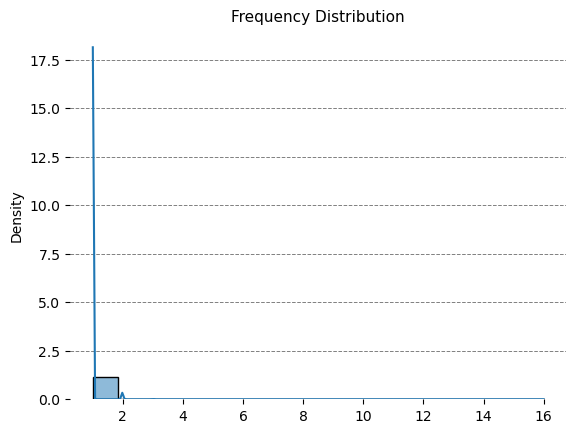

In [281]:
#Number of orders placed by each customer
ax = sns.histplot(data = rfm,
             x = 'frequency',
             kde = True,
             stat = 'density',
             palette = 'Blues')
# Remove the spines (borders)
for spine in ax.spines.values():
    spine.set_visible(False)

# Add gridlines and ensure they are behind the bars
ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7, color='gray')
ax.set_axisbelow(True)
plt.title('Frequency Distribution', fontsize = 11)
plt.xlabel(None)

C:\Users\phuon\AppData\Local\Temp\ipykernel_60040\1792541189.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.histplot(data = rfm,


Text(0.5, 0, '')

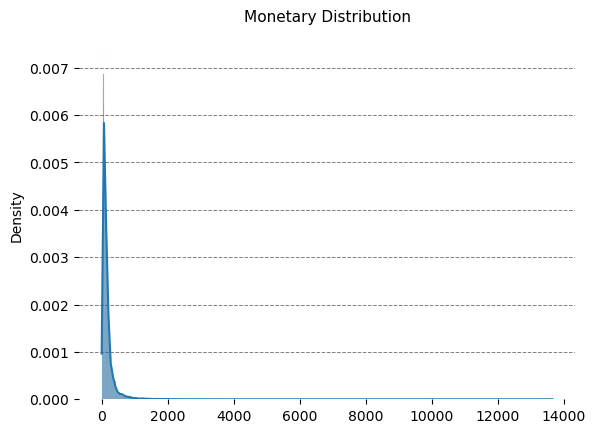

In [283]:
ax = sns.histplot(data = rfm,
             x = 'monetary',
             kde = True,
             stat = 'density',
             palette = 'Blues')
# Remove the spines (borders)
for spine in ax.spines.values():
    spine.set_visible(False)

# Add gridlines and ensure they are behind the bars
ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7, color='gray')
ax.set_axisbelow(True)
plt.title('Monetary Distribution', fontsize = 11)
plt.xlabel(None)

In [285]:
#Anomaly: Why are there customers spending up to 100,000? => Check that anomaly
rfm[rfm['monetary'] > 100000 ]

,customer_unique_id,max_order_purchase_timestamp,recency,frequency,monetary


In [287]:
df[df['customer_unique_id'] == '0a0a92112bd4c708ca5fde585afaa872']

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,...,delivery_time,actual vs estimated dispatch time,actual vs estimated delivery time,total time,year,payment_status,date,day_of_week,day_name,hour
1690,03caa2c082116e1d31e67e9ae3700499,1,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01,1617b1357756262bfa56ab541c47bc16,delivered,2017-09-29 15:24:52,...,7.0,Late,On time,15.0,2017,success,2017-09-29,4,Fri,15
1691,03caa2c082116e1d31e67e9ae3700499,2,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01,1617b1357756262bfa56ab541c47bc16,delivered,2017-09-29 15:24:52,...,7.0,Late,On time,15.0,2017,success,2017-09-29,4,Fri,15
1692,03caa2c082116e1d31e67e9ae3700499,3,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01,1617b1357756262bfa56ab541c47bc16,delivered,2017-09-29 15:24:52,...,7.0,Late,On time,15.0,2017,success,2017-09-29,4,Fri,15
1693,03caa2c082116e1d31e67e9ae3700499,4,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01,1617b1357756262bfa56ab541c47bc16,delivered,2017-09-29 15:24:52,...,7.0,Late,On time,15.0,2017,success,2017-09-29,4,Fri,15
1694,03caa2c082116e1d31e67e9ae3700499,5,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01,1617b1357756262bfa56ab541c47bc16,delivered,2017-09-29 15:24:52,...,7.0,Late,On time,15.0,2017,success,2017-09-29,4,Fri,15
1695,03caa2c082116e1d31e67e9ae3700499,6,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01,1617b1357756262bfa56ab541c47bc16,delivered,2017-09-29 15:24:52,...,7.0,Late,On time,15.0,2017,success,2017-09-29,4,Fri,15
1696,03caa2c082116e1d31e67e9ae3700499,7,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01,1617b1357756262bfa56ab541c47bc16,delivered,2017-09-29 15:24:52,...,7.0,Late,On time,15.0,2017,success,2017-09-29,4,Fri,15
1697,03caa2c082116e1d31e67e9ae3700499,8,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01,1617b1357756262bfa56ab541c47bc16,delivered,2017-09-29 15:24:52,...,7.0,Late,On time,15.0,2017,success,2017-09-29,4,Fri,15


In [289]:
df_order_payments[df_order_payments['order_id'] == '03caa2c082116e1d31e67e9ae3700499']

,order_id,payment_sequential,payment_type,payment_installments,payment_value
52107,03caa2c082116e1d31e67e9ae3700499,1,credit_card,1,13664.08


In [291]:
r_quantiles = np.percentile(rfm['recency' ], [20,40,60,80])
f_quantiles = np.percentile(rfm['frequency'], [20,40,60,80])
m_quantiles = np.percentile(rfm['monetary'], [20,40,60,80])
r_quantiles

array([ 95., 179., 270., 386.])

In [295]:
def RScore(x,quantiles):
  if x <= quantiles[0]:  #Using percentile 20% (index 0)
    return 5
  elif x <= quantiles[1]: #Using percentile 40% (index 1)
    return 4
  elif x <= quantiles[2]: #Using percentile 60% (index 2)
    return 3
  elif x<= quantiles[3]:  #Using percentile 80% (index 3)
    return 2
  else:
    return 1

In [297]:
def FMScore(x, quantiles):
  if x <= quantiles[0]:
    return 1
  elif x<= quantiles[1]:
    return 2
  elif x<= quantiles[2]:
    return 3
  elif x<= quantiles[3]:
    return 4
  else:
    return 5

In [299]:
rfm['r'] = rfm['recency'].apply(RScore, quantiles = r_quantiles)
rfm['f'] = rfm['frequency'].apply(FMScore, quantiles = f_quantiles)
rfm['m'] = rfm['monetary'].apply(FMScore, quantiles = m_quantiles)
rfm.head(5)

,customer_unique_id,max_order_purchase_timestamp,recency,frequency,monetary,r,f,m
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,113,1,141.90,4,1,4
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,116,1,27.19,4,1,1
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,539,1,86.22,1,1,2
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,323,1,43.62,2,1,1
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,290,1,196.89,2,1,4


In [301]:
rfm['score'] = (rfm['r'].astype(str) + rfm['f'].astype(str)+ rfm['m'].astype(str)).astype(int)
rfm.head(5)

,customer_unique_id,max_order_purchase_timestamp,recency,frequency,monetary,r,f,m,score
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,113,1,141.90,4,1,4,414
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,116,1,27.19,4,1,1,411
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,539,1,86.22,1,1,2,112
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,323,1,43.62,2,1,1,211
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,290,1,196.89,2,1,4,214


In [307]:
#Read file csv segment_score
segment_score = pd.read_csv("C:\\Users\\phuon\\Downloads\\segment_score1.csv")

In [309]:
#Join table segment_score  with table rfm:
cst_sgmt = pd.merge(rfm, segment_score, left_on = 'score', right_on = 'SCORES', how = 'inner')
cst_sgmt.head(5)

,customer_unique_id,max_order_purchase_timestamp,recency,frequency,monetary,r,f,m,score,SEGMENT,SCORES
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,113,1,141.90,4,1,4,414,Promising,414
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,116,1,27.19,4,1,1,411,New Customers,411
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,539,1,86.22,1,1,2,112,Lost customers,112
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,323,1,43.62,2,1,1,211,Hibernating customers,211
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,290,1,196.89,2,1,4,214,Cannot Lose Them,214


In [311]:
#Summarize how many customers Olist currently has in different groups
data = cst_sgmt.groupby('SEGMENT').agg(cnt = ('customer_unique_id', 'nunique')).reset_index()\
.sort_values(by = 'cnt', ascending = False)
data.head(2)

,SEGMENT,cnt
9,Promising,33121
7,New Customers,18609


C:\Users\phuon\AppData\Local\Temp\ipykernel_60040\2940062642.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='cnt', y='SEGMENT', data = data, palette = 'Blues')


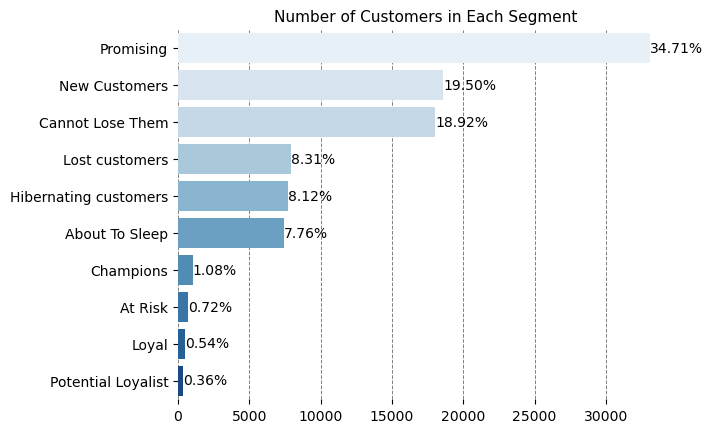

In [321]:
#Draw the barplot:
ax = sns.barplot(x='cnt', y='SEGMENT', data = data, palette = 'Blues')
n = cst_sgmt['customer_unique_id'].nunique()
for p in ax.patches:
    percentage = (p.get_width() / n) * 100  # Calculate percentage
    ax.text(
        p.get_width() + 1,  # Slightly offset the text for better visibility
        p.get_y() + p.get_height() / 2,  # Center the text vertically on the bar
        f'{percentage:.2f}%',  # Format percentage to two decimal place
        va='center'  # Vertical alignment
    )
# Remove the spines (the borders around the plot)
for spine in ax.spines.values():
    spine.set_visible(False)

# Add gridlines and ensure they are behind the bars
ax.grid(True, which='both', axis='x', linestyle='--', linewidth=0.7, color='gray')
ax.set_axisbelow(True)  # Ensure gridlines are below the bars
plt.title('Number of Customers in Each Segment', fontsize = 11)
plt.xlabel('')
plt.ylabel('')
plt.show()

### Opportunity 3: Increase the # of Items/Order

#### Average order size

In [324]:
#How many items do customers purchase per order?
count_item = df.groupby('order_id').agg(count_item = ('order_item_id', 'nunique')).reset_index()
count_item

,order_id,count_item
0,00010242fe8c5a6d1ba2dd792cb16214,1
1,00018f77f2f0320c557190d7a144bdd3,1
2,000229ec398224ef6ca0657da4fc703e,1
3,00024acbcdf0a6daa1e931b038114c75,1
4,00042b26cf59d7ce69dfabb4e55b4fd9,1
...,...,...
98661,fffc94f6ce00a00581880bf54a75a037,1
98662,fffcd46ef2263f404302a634eb57f7eb,1
98663,fffce4705a9662cd70adb13d4a31832d,1
98664,fffe18544ffabc95dfada21779c9644f,1


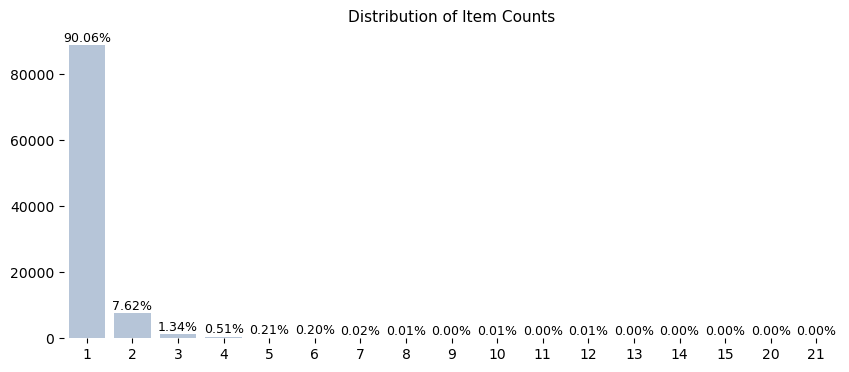

In [346]:
plt.figure(figsize=(10, 4))
ax = sns.countplot(data=count_item, x='count_item', color = 'lightsteelblue')
n = count_item['count_item'].count()
for p in ax.patches:
    ax.annotate(f'{100 * int(p.get_height()) / n:.2f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=9, color='black',
                xytext=(0, 5), textcoords='offset points')

for spine in ax.spines.values():
    spine.set_visible(False)
plt.title('Distribution of Item Counts', fontsize = 11)
plt.xlabel('')
plt.ylabel('')
plt.show()

In [340]:
test=df.groupby(['order_id','year']).agg(count_order=('order_item_id','nunique'),
                                payment_value=('payment_value','sum')).reset_index()
test.describe()

,year,count_order,payment_value
count,98666.000000,98666.000000,98666.000000
mean,2017.541858,1.141731,205.827080
std,0.504554,0.538452,620.726603
min,2016.000000,1.000000,0.000000
25%,2017.000000,1.000000,62.700000
50%,2018.000000,1.000000,109.680000
75%,2018.000000,1.000000,195.910000
max,2018.000000,21.000000,109312.640000


C:\Users\phuon\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


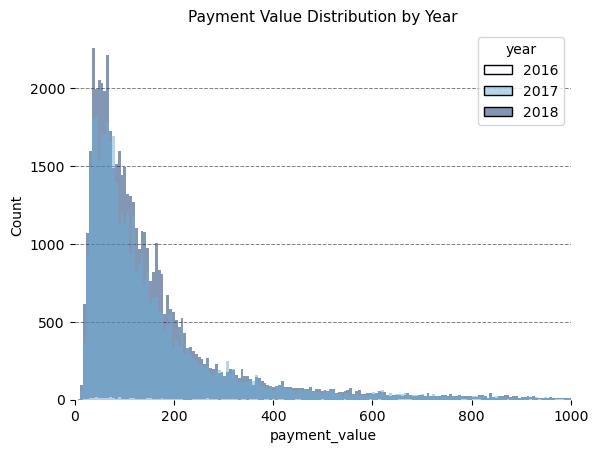

In [348]:
ax = sns.histplot(data=test,
                  x='payment_value',
                  hue='year',
                  palette='Blues', zorder=3)

# Set x-axis limits
plt.xlim(0, 1000)

# Add title and customize font size
plt.title('Payment Value Distribution by Year', fontsize=11)

# Remove spines (borders)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7, color='gray')
ax.set_axisbelow(True)
plt.show()

In [349]:
#Customers purchase 2 products or more
count_item['count_item'].quantile(0.91)

2.0

#### Which products are frequently bought together?

In [353]:
#Which orders contain 2 different products?
df.groupby('order_id').agg(count_pd = ('product_id', 'nunique')).reset_index().sort_values(by = 'count_pd', ascending = False)

,order_id,count_pd
77909,ca3625898fbd48669d50701aba51cd5f,8
48309,7d8f5bfd5aff648220374a2df62e84d5,7
46116,77df84f9195be22a4e9cb72ca9e8b4c2,7
66653,ad850e69fce9a512ada84086651a2e7d,7
36443,5efc0b7fe9df7f0c567404abaa4d25fc,6
...,...,...
33440,56d0a27ec26d1644336aff1ec939c089,1
33439,56d01e37808556640e75a40c8202b0a8,1
33438,56ce64b53ec3bb5b0525f21506619f8e,1
33437,56ce3873eb6d633a47581ec221f50a65,1


In [355]:
pd_tuple = pd.merge(df, df, on = 'order_id', how = 'inner')

In [357]:
pd_tuple = pd_tuple[pd_tuple['product_id_x'] < pd_tuple['product_id_y']]

In [359]:
pd_tuple.head(2)

,order_id,order_item_id_x,product_id_x,seller_id_x,shipping_limit_date_x,price_x,freight_value_x,customer_id_x,order_status_x,order_purchase_timestamp_x,...,delivery_time_y,actual vs estimated dispatch time_y,actual vs estimated delivery time_y,total time_y,year_y,payment_status_y,date_y,day_of_week_y,day_name_y,hour_y
106,002f98c0f7efd42638ed6100ca699b42,2,880be32f4db1d9f6e2bec38fb6ac23ab,fa40cc5b934574b62717c68f3d678b6d,2017-08-10 09:30:15,44.9,7.16,75fd1fb0bb511fc71ac2b2649c02b21b,delivered,2017-08-04 09:19:10,...,3.0,On time,On time,3.0,2017,success,2017-08-04,4,Fri,9
121,00337fe25a3780b3424d9ad7c5a4b35e,2,13944d17b257432717fd260e69853140,cfb1a033743668a192316f3c6d1d2671,2017-09-29 17:50:16,59.9,9.94,4b1b5c848616a4b5fa9d76cb1d12067b,delivered,2017-09-25 17:39:29,...,0.0,On time,On time,1.0,2017,success,2017-09-25,0,Mon,17


In [361]:
#How many order_ids contain the pair of product_id_x and product_id_y:
pd_freq_tuple = pd_tuple.groupby(['product_id_x', 'product_id_y']).agg(count_order = ('order_id', 'nunique')).reset_index()\
.sort_values(by ='count_order', ascending = False)

In [363]:
pd_freq_tuple[pd_freq_tuple['count_order'] > 5]

,product_id_x,product_id_y,count_order
1577,36f60d45225e60c7da4558b070ce4b60,e53e557d5a159f5aa2c5e995dfdf244b,34
1530,35afc973633aaeb6b877ff57b2793310,99a4788cb24856965c36a24e339b6058,29
2161,4fcb3d9a5f4871e8362dfedbdb02b064,f4f67ccaece962d013a4e1d7dc3a61f7,17
1574,36f60d45225e60c7da4558b070ce4b60,3f14d740544f37ece8a9e7bc8349797e,12
1615,389d119b48cf3043d311335e499d9c6b,422879e10f46682990de24d770e7f83d,11
1616,389d119b48cf3043d311335e499d9c6b,53759a2ecddad2bb87a079a1f1519f73,9
1554,368c6c730842d78016ad823897a372db,53759a2ecddad2bb87a079a1f1519f73,8
759,18486698933fbb64af6c0a255f7dd64c,dbb67791e405873b259e4656bf971246,7
1842,422879e10f46682990de24d770e7f83d,53759a2ecddad2bb87a079a1f1519f73,7
439,0d85c435fd60b277ffb9e9b0f88f927a,ee57070aa3b24a06fdd0e02efd2d757d,6


In [365]:
#Which orders contain 2 different products?
df.groupby('order_id').agg(count_pd=('product_id','nunique')).reset_index().sort_values(by='count_pd', ascending=False)

,order_id,count_pd
77909,ca3625898fbd48669d50701aba51cd5f,8
48309,7d8f5bfd5aff648220374a2df62e84d5,7
46116,77df84f9195be22a4e9cb72ca9e8b4c2,7
66653,ad850e69fce9a512ada84086651a2e7d,7
36443,5efc0b7fe9df7f0c567404abaa4d25fc,6
...,...,...
33440,56d0a27ec26d1644336aff1ec939c089,1
33439,56d01e37808556640e75a40c8202b0a8,1
33438,56ce64b53ec3bb5b0525f21506619f8e,1
33437,56ce3873eb6d633a47581ec221f50a65,1
